# Lublin House Prices Prediction

**Author:** Davyd Antoniuk

**Project Goal:** Compare the performance of machine learning and deep learning algorithms in predicting house prices in Lublin.

## 1. Introduction

This project compares the performance of machine learning and deep learning algorithms in predicting house prices in Lublin. The dataset was scraped from [Otodom](https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/lubelskie/lublin/lublin/lublin?viewType=listing&page=), followed by data preprocessing, exploratory analysis, feature engineering, outlier handling, and missing value imputation before model building. Additionally, a function and an application developed to predict new house prices based on trained models.

## 2. Data Collection & Preprocessing

In [1]:
from help_functions import * 
from help_functions import (
    evaluate_model, check_normality, check_feature_importance, detect_outliers_iqr, 
    winsorize_series, get_kdist_plot, compute_weights, plot_metric_comparison, 
    predict_house_price, preprocess_data, train_evaluate, prepare_data_for_stacking, 
    plot_model_performance, plot_shap_explanations
)

c:\Users\davyd\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File `help_functions.py` contains all necessary libraries and functions used in this project.\
File link: https://github.com/davydantoniuk/lublin-house-price-predict/blob/main/help_functions.py

### 2.1 Data Scraping

The dataset was collected by scraping house listings from the [Otodom](https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/lubelskie/lublin/lublin/lublin?viewType=listing&page=) website using `R` with the libraries `rvest`, `dplyr`, and `stringr`. The [scraping R script](https://github.com/davydantoniuk/lublin-house-price-predict/blob/main/data/Web_Otodom_scrapper.Rmd) and the collected dataset is stored in `data/` folder.

### 2.2 Dataset Overview

In [2]:
data = pd.read_csv('data/houses_data.csv')
data.head()

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
0,567 000 zł,4-pokojowe LSM bez prowizji,4 pokoje,52.5 m²,3 piętro,Rury,brak informacji,nie
1,728 500 zł,Idealne mieszkanie 4 Pokoje ! 2 balkony ! Okazja,4 pokoje,77.5 m²,3 piętro,Czechów Północny,2025,tak
2,668 360 zł,Active City etap V | mieszkanie 4-pok. | D1_2_17,4 pokoje,68.2 m²,2 piętro,Wrotków,2026,tak
3,833 414 zł,"Mieszkanie, rynek pierwotny, KONCERTOWA 42",4 pokoje,76.46 m²,1 piętro,Czechów Południowy,2023,tak
4,696 500 zł,4 pokoje na nowym osiedlu blisko Centrum.,4 pokoje,79.6 m²,NaN,Kośminek,2025,tak


- Price – Listing price of the house/apartment.
- Name – Title of the listing.
- Rooms – Number of rooms in the property.
- Area – Total area in square meters.
- Floor – Floor number.
- Region – Region of the property.
- Year – Year of construction.
- Elevator – Indicates if the building has an elevator (Yes(*tak*)/No(*nie*)).

**Why These Features?**

I analyzed Otodom listings before ([web-otodom-analyse-r](https://github.com/davydantoniuk/web-otodom-analyse-r)) and found that these features appear in most listings and have the biggest impact on price. Other features are rarely filled, often missing, and would require much longer scraping time, making them less useful for modeling.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3182 non-null   object
 1   Name      3182 non-null   object
 2   Rooms     3182 non-null   object
 3   Area      3182 non-null   object
 4   Floor     3121 non-null   object
 5   Region    3182 non-null   object
 6   Year      3182 non-null   object
 7   Elevator  3182 non-null   object
dtypes: object(8)
memory usage: 199.0+ KB


The dataset consists of 3182 entries and 8 columns, with all features stored as object (string) type. To ensure proper analysis and modeling, numerical columns need to be converted to their appropriate data types.

In [4]:
print("\nUnique values in each column (excluding 'Name', 'Price' and 'Area'):")
for column in data.columns:
    if column not in ['Name', 'Price', 'Area']:
        unique_values = data[column].unique()
        print(f"{column}: {unique_values}")


Unique values in each column (excluding 'Name', 'Price' and 'Area'):
Rooms: ['4 pokoje' '2 pokoje' '3 pokoje' '1 pokój' '5 pokoi' '6 pokoi'
 '10+ pokoi' '7 pokoi']
Floor: ['3 piętro' '2 piętro' '1 piętro' nan '10+ piętro' '10 piętro' '4 piętro'
 'parter' '6 piętro' '5 piętro' '9 piętro' '7 piętro' '8 piętro'
 'suterena' 'poddasze']
Region: ['Rury' 'Czechów Północny' 'Wrotków' 'Czechów Południowy' 'Kośminek'
 'Wieniawa' 'Ponikwoda' 'Śródmieście' 'Bronowice' 'Węglin Południowy'
 'Dziesiąta' 'Tatary' 'Felin' 'Kalinowszczyzna' 'Sławin' 'Czuby Północne'
 'Konstantynów' 'Szerokie' 'Czuby Południowe' 'Stare Miasto'
 'Za Cukrownią' 'Zemborzyce' 'Węglin Północny' 'Hajdów-Zadębie']
Year: ['brak informacji' '2025' '2026' '2023' '2015' '1980' '1982' '2008' '2024'
 '2018' '2003' '2021' '1976' '1963' '2017' '1969' '2000' '1978' '1975'
 '1983' '1993' '1974' '1995' '2022' '1994' '1897' '1986' '1984' '2010'
 '1988' '1973' '1996' '1967' '1972' '1964' '1998' '2014' '1990' '1977'
 '2005' '2012' '2016' '1

The `Year` column contains the unique value *brak informacji*, which should be replaced with **NaN**. Additionally, it includes unrealistic values like *1650*, *1* and *87*, which need to be handled appropriately. Let's check that observations

In [5]:
data[data["Year"].isin(["1650", "1", "87"])]

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
399,830 000 zł,"Stare Miasto, Idealne Pod Wynajem Krótkoterminowy",3 pokoje,65 m²,2 piętro,Stare Miasto,1650,nie
684,524 000 zł,Trzypokojowe mieszkanie piętro: 1/4,3 pokoje,62 m²,1 piętro,Czuby Północne,1,nie
2559,559 000 zł,Mieszkanie dla rodziny w świetnej lokalizacji,3 pokoje,66 m²,NaN,Czuby Północne,87,nie


The value *87* could likely represent *1987*, so it can be corrected accordingly. However, *1* and *1650* are difficult to interpret, making it more appropriate to replace them with `NaN` for better data consistency.

Additionally, the `Price` column also contains missing values, like *Zapytaj o cenę*, which should be replaced with **NaN**.

In [6]:
data[data["Price"] == "Zapytaj o cenę"].head(1) # Output only one example

,Price,Name,Rooms,Area,Floor,Region,Year,Elevator
33,Zapytaj o cenę,Narcyzowe Wzgórza II | mieszkanie 2-pok. | C_45,2 pokoje,32.33 m²,1 piętro,Ponikwoda,2026,tak


### 2.3 Data type conversions

Replace "Zapytaj o cenę" with NaN, removes non-numeric characters (spaces, "zł"), converts commas to dots, and changes the `Price` column to float.

In [7]:
# Replace 'Zapytaj o cenę' with NaN
data['Price'] = data['Price'].replace('Zapytaj o cenę', np.nan)

# Remove non-numeric characters, replace commas with dots, and convert to float, while keeping NaN values
data['Price'] = data['Price'].str.replace('\xa0', '').str.replace('zł', '').str.replace(',', '.').astype('float32')

Remove spaces and $m^2$ from the `Area` column and convert it to float.

In [8]:
# Remove non-numeric characters and convert 'Area' to float
data['Area'] = data['Area'].str.replace(' ', '').str.replace('m²', '').astype('float32')

Replace "brak informacji" and incorrect values in the `Year` column with NaN, convert valid years, and change the column type to integer while preserving NaN values.

In [9]:
# Replace 'brak informacji' with NaN in 'Year' column
data['Year'] = data['Year'].replace('brak informacji', np.nan)

# Replace '87' with 1987 and '1' with NaN in 'Year' column
data['Year'] = data['Year'].replace({'87': 1987, '1': np.nan, '1650': np.nan})

# Convert 'Year' to integer, while keeping NaN values
data['Year'] = data['Year'].astype(float).astype('Int32')

Replace "nie" with 0 and "tak" with 1 in the `Elevator` column, then convert it to integer.

In [10]:
# Convert 'Elevator' column to 0 if 'nie' and 1 if 'tak'
data['Elevator'] = data['Elevator'].replace({'nie': 0, 'tak': 1}).astype('int32')

Count the occurrences of each unique value in the `Rooms` column and display the results.

In [11]:
# Count the number of rows for each unique value in 'Rooms' column
room_counts = data['Rooms'].value_counts()
print("Number of rows for each unique value in 'Rooms' column:")
print(room_counts)

Number of rows for each unique value in 'Rooms' column:
Rooms
3 pokoje     1364
2 pokoje     1124
4 pokoje      404
1 pokój       232
5 pokoi        46
6 pokoi         7
7 pokoi         3
10+ pokoi       2
Name: count, dtype: int64


There are only two observations in the "Rooms" column that have 10+ rooms, so let's replace them with 10.

In [12]:
# Replace '10+ pokoi' with '10 pokoi' in 'Rooms' column
data['Rooms'] = data['Rooms'].replace('10+ pokoi', '10 pokoi')

# Extract numeric part and convert 'Rooms' to integer
data['Rooms'] = data['Rooms'].str.extract('(\d+)').astype('int32')

In [13]:
# Reorder columns
data = data[['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region', 'Name']]

As I already converse columns to proper data types, now let's check how dataset looks like.

In [14]:
data.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region,Name
0,567000.0,52.500000,0,<NA>,4,3 piętro,Rury,4-pokojowe LSM bez prowizji
1,728500.0,77.500000,1,2025,4,3 piętro,Czechów Północny,Idealne mieszkanie 4 Pokoje ! 2 balkony ! Okazja
2,668360.0,68.199997,1,2026,4,2 piętro,Wrotków,Active City etap V | mieszkanie 4-pok. | D1_2_17
3,833414.0,76.459999,1,2023,4,1 piętro,Czechów Południowy,"Mieszkanie, rynek pierwotny, KONCERTOWA 42"
4,696500.0,79.599998,1,2025,4,NaN,Kośminek,4 pokoje na nowym osiedlu blisko Centrum.


Dataset columns are in correct data types. `Floor` remains as a string because converting it to numbers could mislead the model into interpreting floors as strictly numerical, where higher numbers imply significantly greater height differences.

### 2.4 Check for Duplicate Listings

The scraper can accidentally collect the same listings multiple times, and I didn’t initially account for this when preparing the dataset. Since the model will train on columns excluding `Name`, I will check for duplicates based on all other property attributes to ensure data quality. 

In [15]:
# Count duplicate listings based on all key property attributes
duplicate_counts = data.groupby(['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region']).size()

# Filter and display only duplicates (listings appearing more than once)
duplicates = duplicate_counts[duplicate_counts > 1].reset_index(name='Count')

duplicates.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region,Count
0,239000.0,33.689999,0,1908,2,parter,Dziesiąta,2
1,309100.0,30.910000,1,2025,2,2 piętro,Kośminek,2
2,344817.0,34.830002,1,2025,2,2 piętro,Ponikwoda,2
3,348000.0,42.500000,0,1996,2,4 piętro,Felin,4
4,349000.0,20.000000,1,1970,1,3 piętro,Rury,6


Dataset contains duplicates

Now let's remove duplicates with keeping the first occurrence. 

In [16]:
# Remove duplicate listings but keep one unique instance
data = data.drop_duplicates(subset=['Price', 'Area', 'Elevator', 'Year', 'Rooms', 'Floor', 'Region'], keep='first')

In [17]:
len(data)

2578

After removing duplicates, the dataset decreased from 3182 to 2578 entries.

### 2.5 Missing Values Exploration

Now let's check for missing values in the dataset.

In [18]:
# Assuming 'data' is your DataFrame
missing_data = data.isnull().sum()
print("Missing data in each column:")
print(missing_data)

Missing data in each column:
Price       335
Area          0
Elevator      0
Year        381
Rooms         0
Floor        45
Region        0
Name          0
dtype: int64


Since `Price` is what the model is learning to predict, imputing it can create synthetic labels, which may harm the model's accuracy. So let's drop rows with missing values in the `Price` column.

In [19]:
# Drop rows with missing values in 'Price' column
data = data.dropna(subset=['Price'])

For missing values in `Year` and `Floor`, I will first handle them appropriately. Instead of using simple methods like *mean*, *median*, or *mode*, I will analyze the correlation matrix to explore relationships between features and determine if regression-based imputation is a better approach.

**Correlation matrix**

As I wrote before, since the `Floor` column is categorical, converting it directly to numerical values could mislead the model. A better approach is to use one-hot encoding for modeling. However, to analyze correlations and explore regression-based imputation, I will first create a temporary dataset where Floor is converted to numerical values to check the correlation matrix.

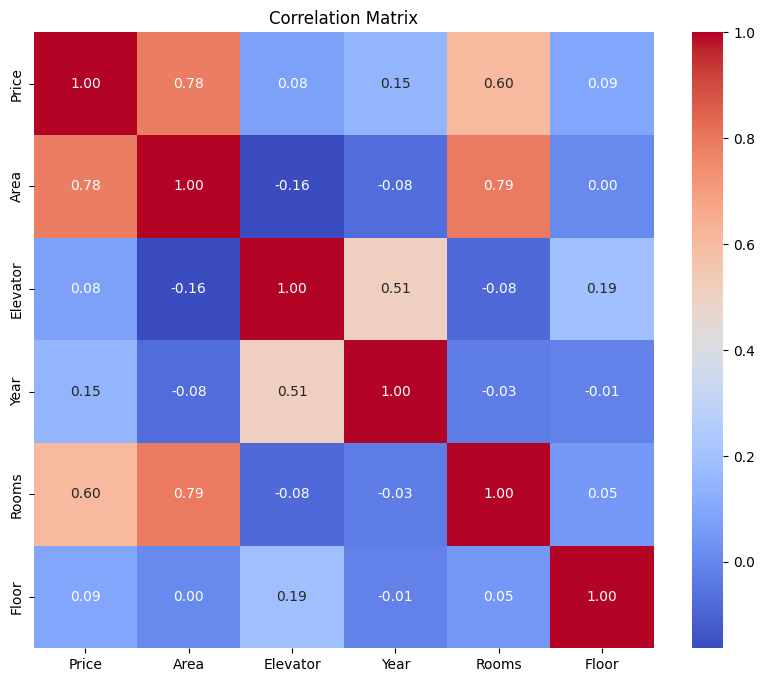

In [20]:
# Create a copy of the DataFrame
data_corr = data.copy(deep=True)
data_corr["Floor"] = data_corr["Floor"].str.extract('(\d+)').astype('Int32')

# Select only numeric columns
numeric_data = data_corr.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The `Year` and `Floor` columns show very low correlation with other features, meaning that using **regression-based imputation** to predict their missing values would not be a reliable approach.\
Additionally, we observe *high correlations* between:
- `Price` and `Area` (0.78)
- `Price` and `Rooms` (0.6)
- `Rooms` and `Area` (0.79)

These correlations are logically expected, as larger properties typically have more rooms and higher prices. 

There is also a moderate correlation (0.51) between `Year` and `Elevator`, which suggests that newer buildings are more likely to have elevators. This is reasonable, as modern construction standards often include elevators, while older buildings may lack them.


To fill the missing values in Year and Floor, I will use a `KNN Imputer`, which leverages similar observations to estimate missing values.

At this step, I couldn't use `KNN Imputer` because, as I researched, KNN imputation requires standardization first due to how distance calculations work.  

I will perform imputation in later steps. 

---

**When is better to use KNN imputer before or after standardization?**\
https://datascience.stackexchange.com/questions/53138/which-comes-first-multiple-imputation-splitting-into-train-test-or-standardiz
>If you use something like KNN imputation then it is necessary to standardize and then impute due to how distance calculations work

---

Now let's build premilinary model to check how it performs on the dataset. But before that I will save the dataset to a new file with `Name` column, which I will use later once in **EDA**. 

For the model this column does not provide any valuable information. I scraped that column to verify if scrapper works correctly, because in the names there are often information about the number of rooms, area, region etc.

In [21]:
# Save converted data 
data.to_csv('data/conversion_data.csv', index=False)

In [22]:
# Drop 'Name' column
data = data.drop("Name", axis=1)

### 2.6 Preliminary Random Forest Model

I build this preliminary Random Forest model to establish a baseline performance before any transformations and handling missing values, helping to compare improvements in later stages.

For building this model, I use **One-Hot Encoding** since I couldn't find strong sources proving that trees work better with Label Encoding or One-Hot Encoding. For now, I choose One-Hot Encoding, but in future steps, I will experiment more because the best technique is the one that gives the best model performance.

In [23]:
data_rf1 = data.copy()

# Drop rows with missing values in 'Price' column
data_rf1 = data_rf1.dropna(subset=['Price'])

# One-hot encode 'Floor' and 'Region' columns
data_rf1 = pd.get_dummies(data_rf1, columns=['Floor', 'Region'], drop_first=True)

# Define features and target
features = data_rf1.drop('Price', axis=1)
target = data_rf1['Price']

# Split the data into train and test sets
X_train_rf1, X_test_rf1, y_train_rf1, y_test_rf1 = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model1.fit(X_train_rf1, y_train_rf1)

# Predict on test set
y_pred = rf_model1.predict(X_test_rf1)

# Evaluate the model
rf1_r2, rf1_mae, rf1_mse, rf1_rmse, rf1_mape, rf1_rmsle = evaluate_model(y_test_rf1, y_pred)
print(f"R^2: {rf1_r2:.4f}")
print(f"MAE: {rf1_mae:.2f}")       
print(f"RMSE: {rf1_rmse:.2f}")
print(f"MAPE: {rf1_mape:.2f}")
print(f"RMSLE: {rf1_rmsle:.4f}")

R^2: 0.8180
MAE: 52997.79
RMSE: 84562.87
MAPE: 8.83
RMSLE: 0.1257


The Random Forest model initially performed well despite missing values, achieving an $R^2$ score of 81.8%. The **MAE** of 52997.79 and **MAPE** of 8.83% suggest relatively low average errors, while the larger **RMSE** of 84562.87 meaning that a few predictions have very high deviations from the actual prices.

So, there is still *room for improvement*.

Let's additionally check the feature importance to understand which features have the most significant impact on price prediction.

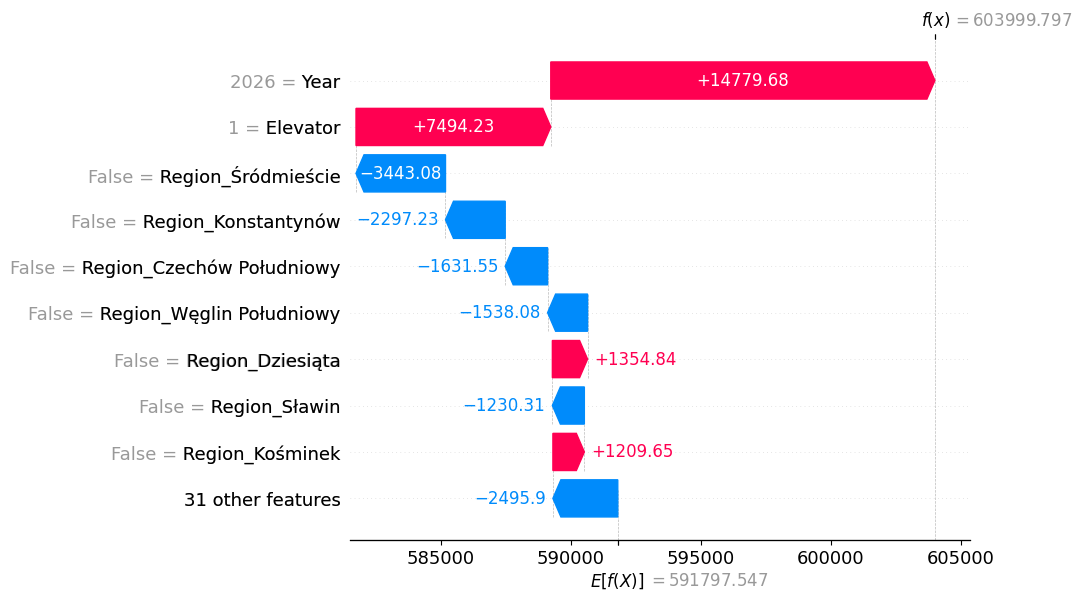

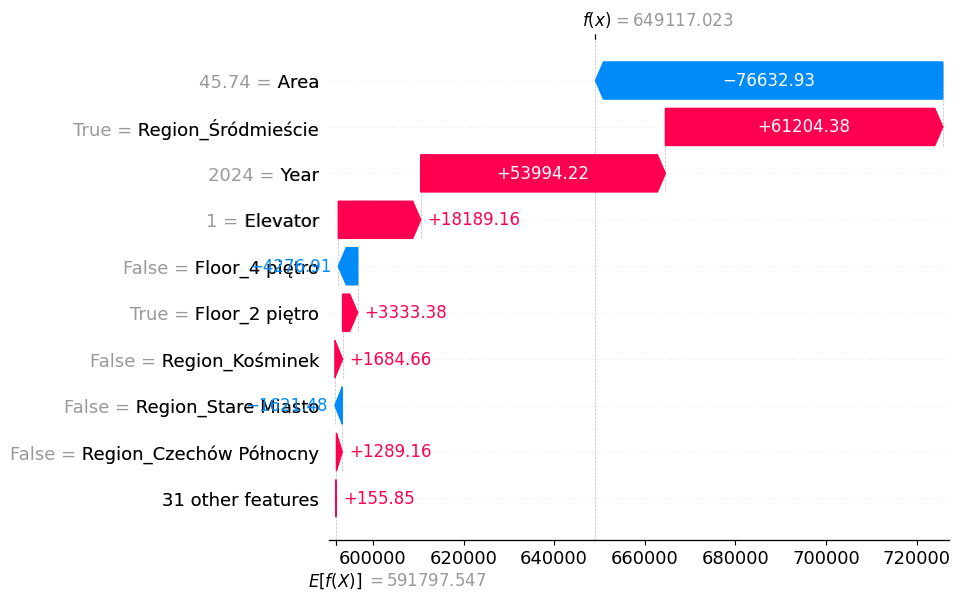

In [24]:
check_feature_importance(rf_model1, X_test_rf1,num_observations=2,random_seed=45)

For two different observations, different features had a dominant impact, showing that the model effectively considers multiple factors when predicting house prices. This highlights that features included in the model play a significant role in shaping predictions. 

## 3. Exploratory Data Analysis

Again look on the dataset to check if everything is correct.

In [25]:
data.head()

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,567000.0,52.500000,0,<NA>,4,3 piętro,Rury
1,728500.0,77.500000,1,2025,4,3 piętro,Czechów Północny
2,668360.0,68.199997,1,2026,4,2 piętro,Wrotków
3,833414.0,76.459999,1,2023,4,1 piętro,Czechów Południowy
4,696500.0,79.599998,1,2025,4,NaN,Kośminek


### 3.1 Basic Statistics

Since we have already cleaned the data, we can now study it in more detail

Let's see basic statistics of the dataset

In [26]:
numerical_cols = ["Price", "Area", "Elevator", "Year", "Rooms"]

# Basic statistics for numerical columns
numerical_stats = data[numerical_cols].describe().round(2)

numerical_stats

,Price,Area,Elevator,Year,Rooms
count,2243.00,2243.00,2243.00,1911.0,2243.00
mean,590925.19,56.06,0.52,2002.27,2.70
std,204863.22,19.66,0.50,29.25,0.89
min,99000.00,13.50,0.00,1815.0,1.00
25%,465839.00,44.12,0.00,1981.0,2.00
50%,554904.00,53.96,1.00,2018.0,3.00
75%,668000.00,64.07,1.00,2024.0,3.00
max,2900000.00,314.00,1.00,2027.0,10.00


- **Price**  
    Prices range from **99,000 PLN to 2,900,000 PLN**, with most listings between **465,839 PLN** and **668,000 PLN**. The high standard deviation (**204,863 PLN**) indicates price variation, with an average price of **590,925 PLN**.

- **Area**  
    The average property size is **56.06 m²**, with most ranging between **44.12 m² and 64.07 m²**. There is moderate variation, but some large properties reach up to **314 m²**.  

- **Elevator**  
    About **52%** of properties have an elevator.  

- **Year**  
    The median year (**2018**) is significantly higher than the mean (**2002**) due to the presence of older buildings dating back to **1815**, which skews the average downward. Additionally, the years **2026 and 2027** indicate properties that are still under construction or planned for the future.  

- **Rooms**  
    Most properties have **2 to 3 rooms**, with an average of **2.7 rooms**. The number of rooms ranges from **1 to 10**, though larger apartments (**5+ rooms**) are less common. 🚀

In [27]:
categorical_cols = ["Floor", "Region"]

# Basic statistics for categorical columns 
categorical_stats = pd.DataFrame({
    "Unique Values": data[categorical_cols].nunique(),
    "Most Common Value": data[categorical_cols].mode().iloc[0],
    "Frequency": data[categorical_cols].apply(lambda x: x.value_counts().iloc[0])
})

categorical_stats

,Unique Values,Most Common Value,Frequency
Floor,14,1 piętro,458
Region,24,Śródmieście,227


The dataset includes 14 unique floor levels, with "1 piętro" being the most common (458 listings). Among 24 regions, "Śródmieście" appears most frequently (227 listings).

### 3.2 Price and Area Distribution

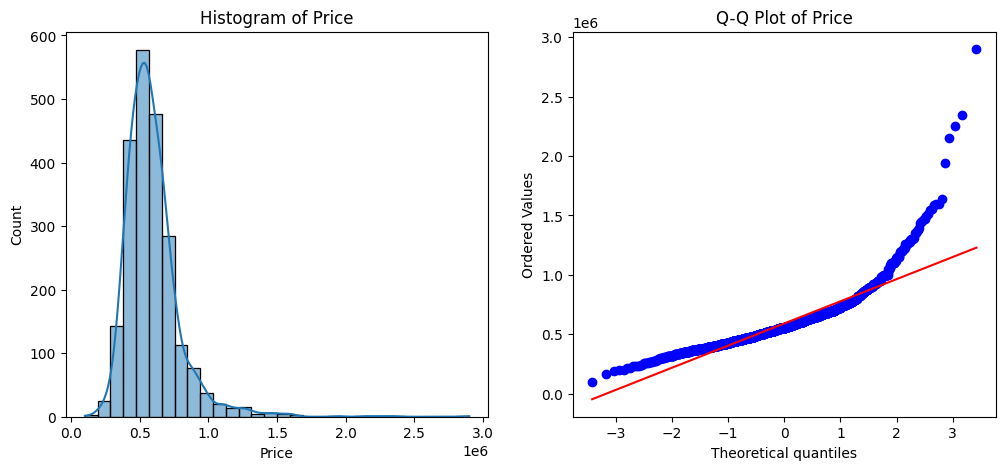

Normality Tests for Price:
  Shapiro-Wilk Test: W=0.8276, p-value=0.0000
  D'Agostino's K² Test: Stat=1428.4119, p-value=0.0000
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


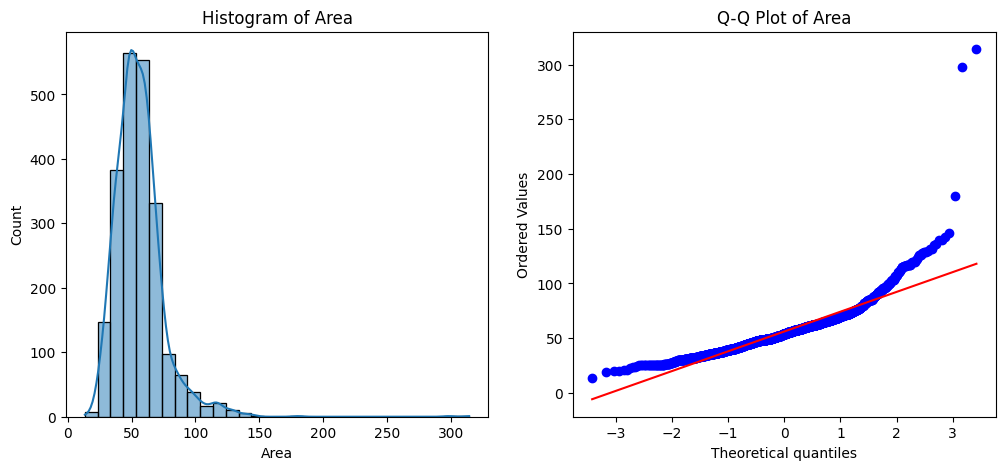

Normality Tests for Area:
  Shapiro-Wilk Test: W=0.8456, p-value=0.0000
  D'Agostino's K² Test: Stat=1598.3768, p-value=0.0000
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


In [28]:
cols = ["Price", "Area"]
check_normality(data, cols)

Both `Price` and `Area` failed the normality tests. This indicates that these variables are skewed or contain outliers. On Q-Q plots, we can notice distanced points from the line, which confirms the presence of outliers. 

### 3.4 Price per sqm Analysis

Price per sqm is a key metric for comparing properties as it helps detect overpriced or undervalued listings

So, I will create a separate dataset and add the price per sqm column

In [29]:
# Create a separate dataset for price per sqm analysis
data_pricesqm = data.copy(deep=True)

# Calculate price per square meter
data_pricesqm['Price_per_sqm'] = data_pricesqm['Price'] / data_pricesqm['Area']

Now let's check the normality of the price per sqm

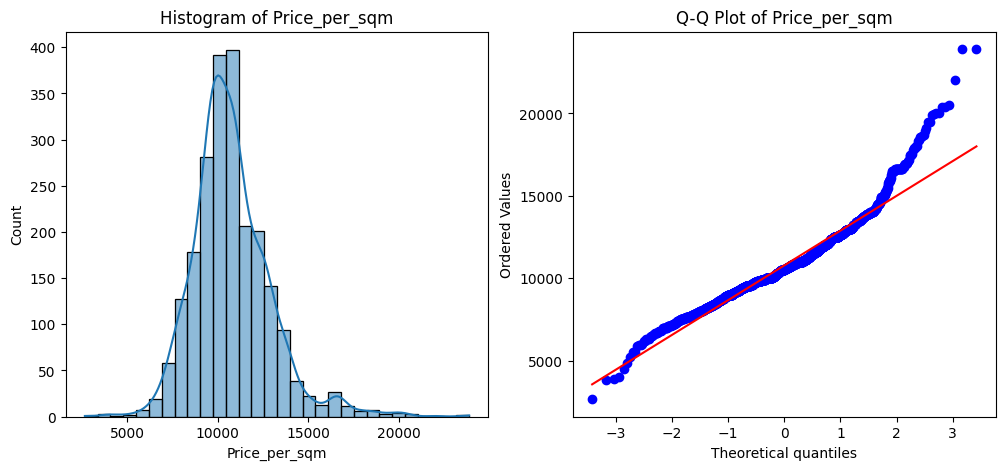

Normality Tests for Price_per_sqm:
  Shapiro-Wilk Test: W=0.9441, p-value=0.0000
  D'Agostino's K² Test: Stat=470.0948, p-value=0.0000
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


In [30]:
cols = ["Price_per_sqm"]
check_normality(data_pricesqm, cols)

The `Price_per_sqm` distribution is **not normal**, as shown by the histogram, Q-Q plot deviations, and rejected normality tests. It has slight skewness and some outliers.

Statistics for Price_per_sqm

In [31]:
# Display statistics for Price_per_sqm
price_per_sqm_stats = data_pricesqm['Price_per_sqm'].describe()
print(price_per_sqm_stats)

count     2243.000000
mean     10778.232422
std       2168.186768
min       2666.631836
25%       9500.000000
50%      10521.500000
75%      11896.666504
max      23900.000000
Name: Price_per_sqm, dtype: float64


The average price per sqm is **10,778 PLN**, with most values ranging between **9,500 PLN (25%)** and **11,896 PLN (75%)**. The distribution has a **wide spread (std: 2,168 PLN)** and some **high-value outliers**, reaching a maximum of **23,900 PLN**, while the minimum is **2,667 PLN**. 

Create a boxplot to detect outliers

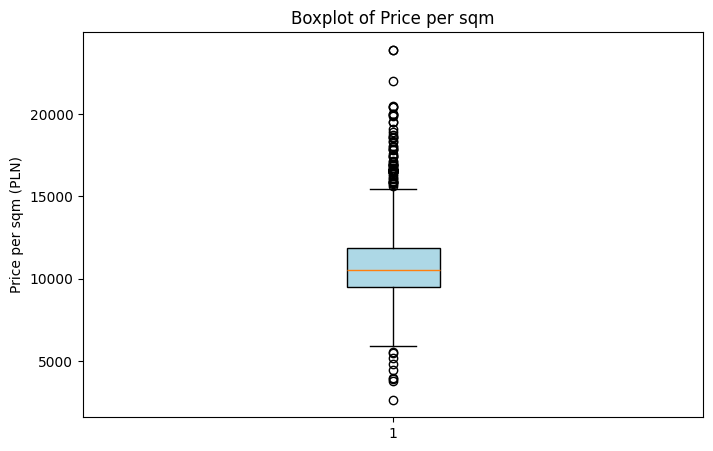

In [32]:
# Boxplot for Price_per_sqm
plt.figure(figsize=(8, 5))
plt.boxplot(data_pricesqm['Price_per_sqm'].dropna(), patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot of Price per sqm")
plt.ylabel("Price per sqm (PLN)")
plt.show()

The boxplot confirms the presence of many outliers, both on the lower and higher ends of price per sqm. Most values fall between ~9,500 PLN and ~12,000 PLN, with a few extreme cases exceeding 20,000 PLN. The distribution is slightly right-skewed, indicating that some high-end properties significantly raise the upper range.

Outliers in `price per sqm` can indicate **data entry errors**, **luxury properties**, or **undervalued listings.** By examining properties below the lower whisker and above 20,000 PLN per sqm, I can better understand market anomalies and decide whether to remove, adjust, or keep them for modeling.

To ensure if this is outliers or not I will additionally output `Name` column to check if there are any valuable information about the properties.

In [33]:
# Define IQR boundaries
Q1 = data_pricesqm['Price_per_sqm'].quantile(0.25)
Q3 = data_pricesqm['Price_per_sqm'].quantile(0.75)
IQR = Q3 - Q1

# Lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter lower outliers (unusually cheap properties)
low_outliers = data_pricesqm[data_pricesqm['Price_per_sqm'] < lower_bound]

# Filter high outliers (luxury or overpriced properties above 20,000 PLN per sqm)
high_outliers = data_pricesqm[data_pricesqm['Price_per_sqm'] > 20000]

# Load the dataset with property names
conversion_data = pd.read_csv("data/conversion_data.csv")  # Load full dataset

# Merge based on matching 'Price' and 'Region' to reduce NaNs
low_outliers = low_outliers.merge(
    conversion_data, 
    on=['Price', 'Region'], 
    how='left'
)

high_outliers = high_outliers.merge(
    conversion_data, 
    on=['Price', 'Region'], 
    how='left'
)

# Display all columns for deeper analysis
print("Lower outliers (unusually cheap properties):")
display(low_outliers)

print("High outliers (luxury or overpriced properties):")
display(high_outliers)

Lower outliers (unusually cheap properties):


,Price,Area_x,Elevator_x,Year_x,Rooms_x,Floor_x,Region,Price_per_sqm,Area_y,Elevator_y,Year_y,Rooms_y,Floor_y,Name
0,499000.0,128.000000,0,1960,4,4 piętro,Tatary,3898.437500,128.00,0,1960.0,4,4 piętro,Mieszkanie antresola+klimatyzacja 128m² użytko...
1,99000.0,19.000000,0,<NA>,1,parter,Dziesiąta,5210.526367,19.00,0,NaN,1,parter,Kawalerka ⭐️ ul. Kunickiego ⭐️ Okazja
2,190237.5,71.339996,0,<NA>,4,NaN,Czuby Południowe,2666.631836,71.34,0,NaN,4,NaN,"Mieszkanie ul. Ametystowa ,Lublin"
3,385000.0,79.150002,0,1910,4,3 piętro,Śródmieście,4864.181641,48.00,0,1969.0,3,4 piętro,"Mieszkanie, Kalinowszczyzna, ul. Okrzei, 48 m2"
4,385000.0,79.150002,0,1910,4,3 piętro,Śródmieście,4864.181641,79.15,0,1910.0,4,3 piętro,Czteropokojowe mieszkanie w ścisłym centrum Lu...
5,169000.0,37.549999,0,<NA>,2,2 piętro,Śródmieście,4500.666016,37.55,0,NaN,2,2 piętro,*Centrum*2 pokoje*z najemcami*inwestycja*
6,270000.0,49.000000,0,<NA>,2,parter,Dziesiąta,5510.204102,49.00,0,NaN,2,parter,Mieszkanie w kaminiecy przy ulicy Dziesiątej
7,475000.0,124.000000,0,1980,5,1 piętro,Kośminek,3830.645264,124.00,0,1980.0,5,1 piętro,Mieszkanie z prywatnym ogrodem
8,428000.0,107.000000,0,1910,2,1 piętro,Dziesiąta,4000.000000,107.00,0,1910.0,2,1 piętro,Dwa mieszkania w kamienicy o pow.107 m2. Udziały.
9,999000.0,180.000000,0,1998,5,3 piętro,Czechów Północny,5550.000000,180.00,0,1998.0,5,3 piętro,"Dwupoziomowe, 5 Pokoi Po Remoncie, Piwnica, Garaż"


High outliers (luxury or overpriced properties):


,Price,Area_x,Elevator_x,Year_x,Rooms_x,Floor_x,Region,Price_per_sqm,Area_y,Elevator_y,Year_y,Rooms_y,Floor_y,Name
0,956000.0,40.000000,1,2023,2,2 piętro,Śródmieście,23900.0,40.00,1,2023.0,2,2 piętro,Mieszkanie W Centrum O Wysokim Standardzie
1,752850.0,31.500000,1,2023,2,2 piętro,Śródmieście,23900.0,31.50,1,2023.0,2,2 piętro,Mieszkanie W Centrum O Wysokim Standardzie
2,1439305.0,70.209999,1,2022,2,2 piętro,Śródmieście,20500.0,70.21,1,2022.0,2,2 piętro,Apartament 2- pok. centrum- Litevski Art Resid...
3,927384.0,45.459999,1,<NA>,2,4 piętro,Śródmieście,20400.0,45.46,1,NaN,2,4 piętro,"Mieszkanie, 45,46 m², Lublin"
4,954720.0,46.799999,1,2024,3,4 piętro,Śródmieście,20400.0,46.80,1,2024.0,3,4 piętro,Niecała Prestige Residence | nowe mieszkanie M24
5,858000.0,39.000000,1,<NA>,2,parter,Śródmieście,22000.0,39.00,1,NaN,2,parter,"Mieszkanie, 39 m², Lublin"


The advertisements mostly **look like normal listings**, and the names don’t reveal clear anomalies. This makes it **risky to remove them**, as they could be legitimate properties rather than errors.

### 3.4 Regional Analysis

Number of unique values for each region.

In [34]:
data["Region"].value_counts()

Region
Śródmieście           227
Sławin                212
Ponikwoda             191
Wrotków               187
Czechów Południowy    173
Czechów Północny      162
Rury                  155
Węglin Południowy     148
Wieniawa              108
Dziesiąta              92
Kośminek               87
Czuby Północne         85
Bronowice              65
Stare Miasto           65
Kalinowszczyzna        60
Konstantynów           60
Tatary                 50
Czuby Południowe       47
Felin                  37
Szerokie               14
Za Cukrownią           11
Zemborzyce              3
Węglin Północny         2
Hajdów-Zadębie          2
Name: count, dtype: int64

**Śródmieście**, **Sławin**, and **Ponikwoda** have the highest number of listings, while **Węglin Północny** and **Hajdów-Zadębie** have the fewest. Regions with very few listings might make predictions less accurate. To improve the model, it could help to group similar regions or apply techniques like *weighting* or *regularization*. . I will describe my approach in the later part of the project.

**Bar chart**: Average price per region to identify the most expensive and cheapest areas.

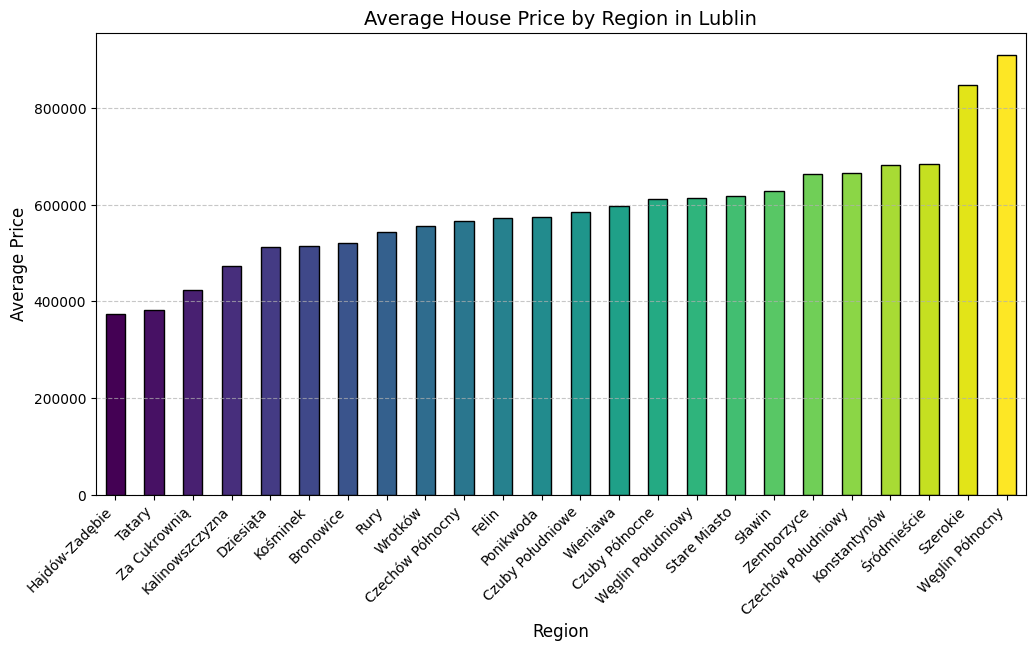

In [35]:
region_avg_price = data.groupby("Region")["Price"].mean().sort_values()

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(region_avg_price)))

# Plot the bar chart
plt.figure(figsize=(12, 6))
region_avg_price.plot(kind="bar", color=colors, edgecolor="black")
plt.xlabel("Region", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.title("Average House Price by Region in Lublin", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Węglin Północny** and **Szerokie** has the highest average house prices, while **Hajdów-Zadębie** has the lowest. The significantly higher average price in **Węglin Północny** and **Szerokie** might be due to the availability of a larger number of apartments in that region. So let's verify it with *pandas*.

In [36]:
filtered_data = data[(data["Region"].isin(["Węglin Północny", "Szerokie"])) & (data["Rooms"] > 4)]
room_count = filtered_data["Region"].value_counts()
display(filtered_data)
    
room_count

,Price,Area,Elevator,Year,Rooms,Floor,Region
444,999000.0,140.0,0,2000,5,1 piętro,Węglin Północny
2937,2900000.0,298.0,0,2003,10,1 piętro,Szerokie


Region
Węglin Północny    1
Szerokie           1
Name: count, dtype: int64

The high average prices in Węglin Północny and Szerokie are likely due to the low number of listings and the presence of more expensive, large apartments, which highly increase the average price.

### 3.5 Floor Analysis

Number of unique values for each floor level.

In [37]:
data['Floor'].value_counts()

Floor
1 piętro      458
3 piętro      431
parter        413
2 piętro      391
4 piętro      249
5 piętro       93
6 piętro       61
7 piętro       35
9 piętro       22
10 piętro      20
8 piętro       15
10+ piętro      8
suterena        1
poddasze        1
Name: count, dtype: int64

Similar to `Regions`, the distribution of listings across `Floors` is uneven. Lower **floors (1-4) and parter** have significantly more listings, while higher **floors (8+)** and unique categories like **suterena** and **poddasze** have very few. This imbalance also could affect model accuracy, as it may struggle to predict prices for less common floor types. In the later part of the project, I will outline my approach to address this issue and ensure a more balanced model. 

**Bar chart**: Average price per floor category to determine which floor levels are most expensive.

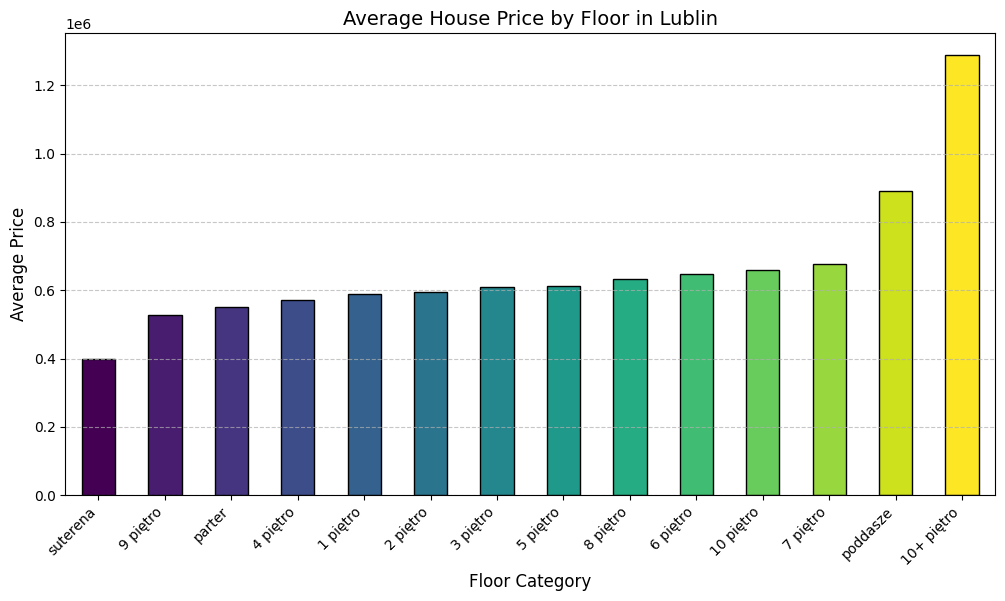

In [38]:
# Group by Floor and calculate the average price
floor_avg_price = data.groupby("Floor")["Price"].mean().sort_values()

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(floor_avg_price)))

# Plot the bar chart
plt.figure(figsize=(12, 6))
floor_avg_price.plot(kind="bar", color=colors, edgecolor="black")
plt.xlabel("Floor Category", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.title("Average House Price by Floor in Lublin", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Most floors have relatively stable average prices, but **poddasze** and **10+ piętro** stand out with significantly higher prices. This could be due to penthouse apartments or luxury properties on these floors, in next step we check it. **Suterena** has the lowest average price, likely due to lower demand. Other floar levels have similar average prices, indicating that floor level alone may not be a strong predictor of price.


Let's check the observations where the floor is *poddasze*, *suterena* and *10+ piętro* to verify how they look like.

In [39]:
# Filtering the dataset for the specified floor categories: "poddasze", "suterena", and "10+ piętro"
filtered_floors = data[data["Floor"].isin(["poddasze", "suterena", "10+ piętro"])]
grouped_floors = filtered_floors.groupby("Floor").apply(lambda x: x.head(20)).reset_index(drop=True)
grouped_floors

,Price,Area,Elevator,Year,Rooms,Floor,Region
0,538000.0,41.439999,1,2015,2,10+ piętro,Rury
1,1499000.0,88.199997,1,2019,4,10+ piętro,Czechów Południowy
2,1299000.0,81.000000,1,2013,3,10+ piętro,Rury
3,585000.0,33.330002,1,2023,2,10+ piętro,Czechów Południowy
4,1450000.0,103.010002,1,2023,5,10+ piętro,Czechów Południowy
5,530000.0,48.200001,1,1977,3,10+ piętro,Stare Miasto
6,2150000.0,130.000000,1,2013,4,10+ piętro,Czechów Południowy
7,2250000.0,131.199997,1,2020,5,10+ piętro,Czechów Południowy
8,890000.0,85.000000,0,1911,5,poddasze,Dziesiąta
9,399000.0,60.500000,0,1992,3,suterena,Sławin


**poddasze** is one old apartment with 5 rooms, which could explain it's high price.\
**suterena** is an average area building with 3 rooms, likely contributing to its lower price. \
**10+ piętro** show a wide range of prices, likely influenced by area, number of rooms, and location. Large aprtment with 10 rooms and 314 m² area has the highest price, but this is too strange observation, because is too large for 10+ floor. It could be a mistake made by the author of the announcement, so I will remove this observation.

In [40]:
data = data.drop(data[(data['Area'] == 314.0) & (data['Floor'] == "10+ piętro")].index)

### 3.6 Temporal Trends

**Scatter plot**: Year vs. Price to see if newer buildings are more expensive.

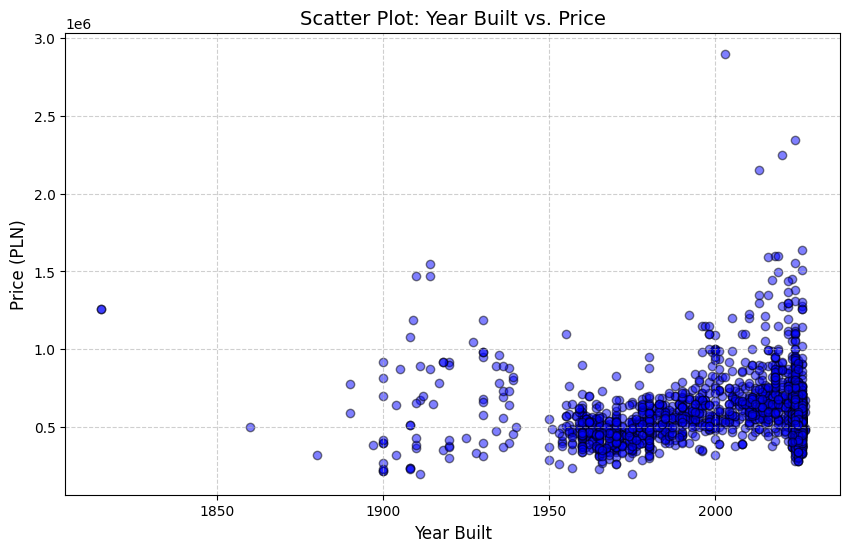

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(data["Year"], data["Price"], alpha=0.5, color="blue", edgecolors="black")

# Labels and title
plt.xlabel("Year Built", fontsize=12)
plt.ylabel("Price (PLN)", fontsize=12)
plt.title("Scatter Plot: Year Built vs. Price", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

The scatter plot shows a weak relationship between year built and price, meaning newer buildings are not always more expensive. 
- There is one outlier from before 1850, which may be a historic or incorrectly recorded property.
- The 1850-1950 range has very few observations, which could make predictions for older buildings unreliable.
- This imbalance may affect model accuracy, as it will have less data to learn patterns for very old properties.

Additionally, there are four observations with significantly higher prices, which also is necessary to check.

### 3.7 Elevator Analysis

- **Bar chart**: Average price comparison for properties with and without elevators.
- **Stacked bar chart**: Number of properties with and without elevators per floor category.

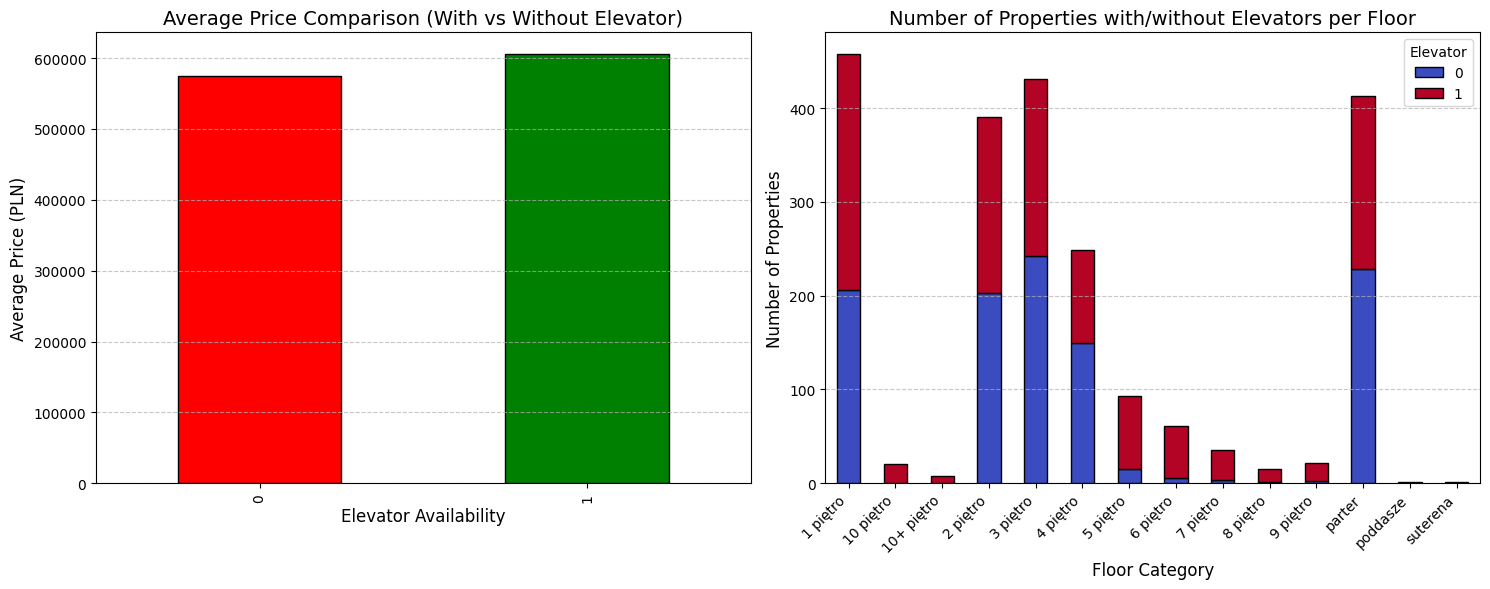

In [42]:
# First plot: Average price comparison for properties with and without elevators
avg_price_elevator = data.groupby("Elevator")["Price"].mean()

# Second plot: Stacked bar chart - Number of properties with and without elevators per floor category
elevator_per_floor = data.groupby(["Floor", "Elevator"]).size().unstack(fill_value=0)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart: Average price comparison
avg_price_elevator.plot(kind="bar", ax=axes[0], color=["red", "green"], edgecolor="black")
axes[0].set_xlabel("Elevator Availability", fontsize=12)
axes[0].set_ylabel("Average Price (PLN)", fontsize=12)
axes[0].set_title("Average Price Comparison (With vs Without Elevator)", fontsize=14)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Stacked bar chart: Number of properties with and without elevators per floor
elevator_per_floor.plot(kind="bar", stacked=True, ax=axes[1], colormap="coolwarm", edgecolor="black")
axes[1].set_xlabel("Floor Category", fontsize=12)
axes[1].set_ylabel("Number of Properties", fontsize=12)
axes[1].set_title("Number of Properties with/without Elevators per Floor", fontsize=14)
axes[1].legend(title="Elevator", loc="upper right")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels for better readability
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Show the plots
plt.tight_layout()
plt.show()

As we remember from basic statistics, about 52% of properties have an elevator. The average price for properties with elevators is few higher than for those without, but the difference is not significant. Higher floors buildings mostly have elevators, while in advertisements with lower floors, the presence of an elevator is less common.

### 3.8 Price and Property Characteristics

In this section, I will analyze key property characteristics - price, area, and number of rooms—using box plots. These visualizations help identify the **distribution**, **spread**, and **presence of outliers** in each variable.

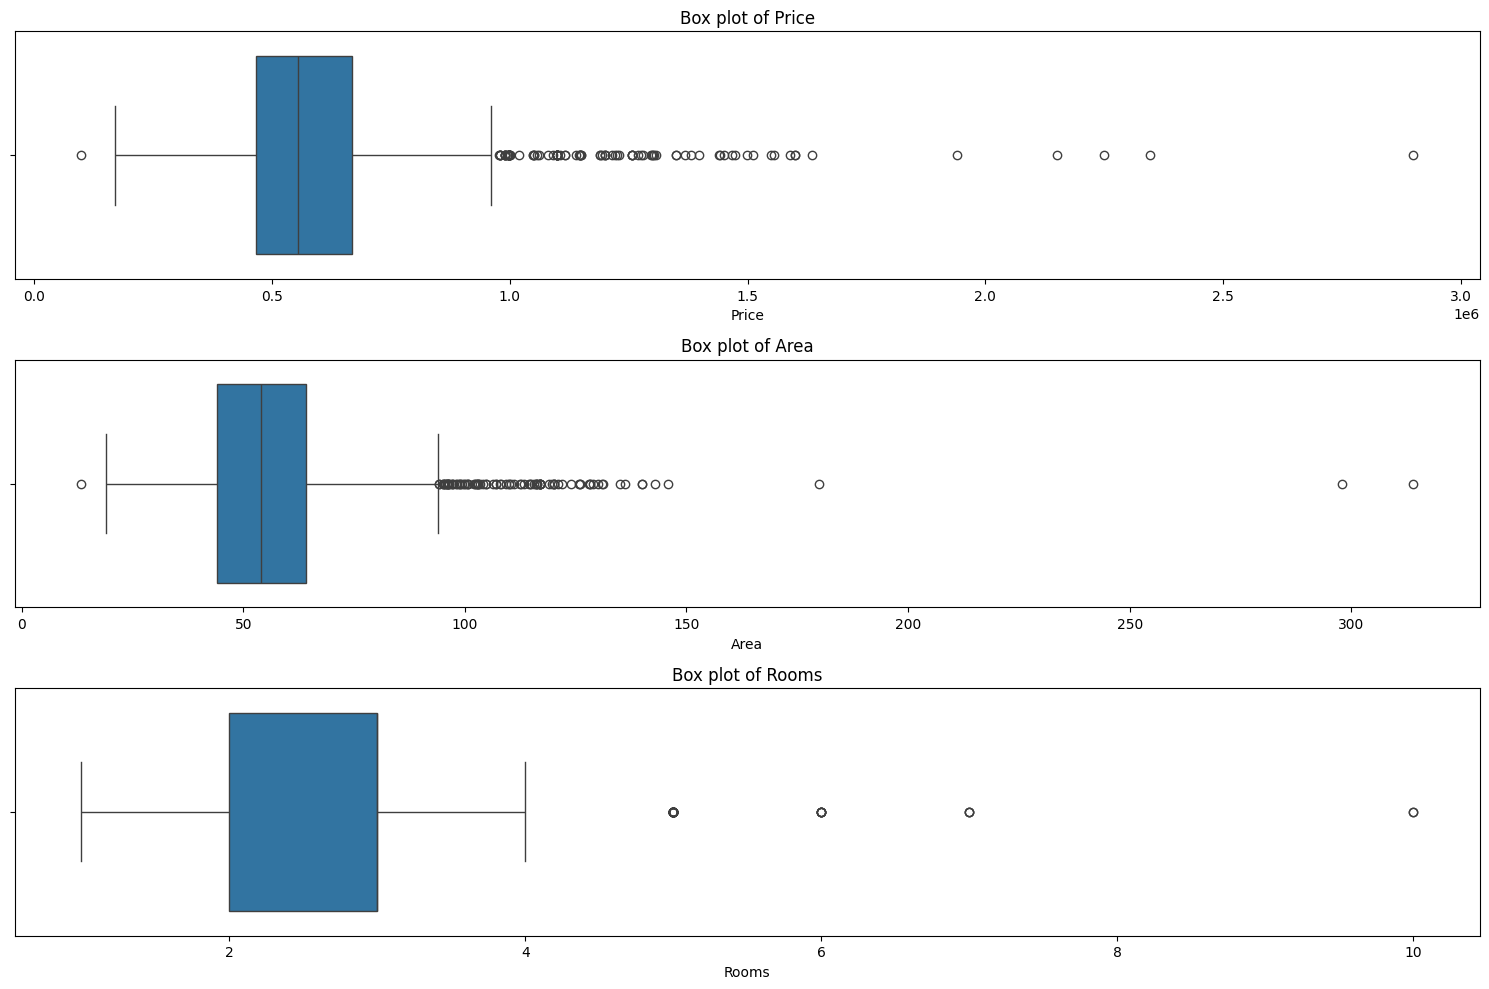

In [43]:
numerical_columns = ['Price', 'Area', 'Rooms']
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=data[column], orient='h')
    plt.title(f'Box plot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

**Box Plot of Price**
Most house prices fall within a certain range, with a few outliers extending significantly beyond 1,500,000 PLN. The median price is located in the lower portion of the box, suggesting that most properties are closer to the lower price range.

**Box Plot of Area**
Most house areas are between approximately 30 sqm and 100 sqm.There are several outliers representing houses with exceptionally large areas (over 150 sqm).

**Box Plot of Rooms:**
The majority of listings have 2 to 4 rooms. However, there are several outliers with 5+ rooms.

### 3.9 Analysis Results

Such a broad analysis helped us to familiarize ourselves with the data and understand its concept in more detail. Each step of the analysis revealed strange ads, a lack of relevant types, and outliers in the data. 

- Price and area do not follow a normal distribution, with a right skew indicating.
- Imbalanced number of observations across regions.
- Imbalanced floor distribution.
- Outliers in Price, Area, Rooms, and Year, with extreme values that may indicate errors.
- Price per sqm shows high variability, with some extreme outliers.

So in next stage, I will address these issues and prepare the data for modeling.

## 4. Feature Engineering & Data Preparation

### 4.1 Floor Feature Transformation

In this step, I will transform the `Floor` feature in the next way:
-  Replace `suterena` and `poddasze` 
-  **Group higher floors**: Merge all floors 5 and above  into a single `5+ piętro` category to balance the dataset.

I found by key words in advertisements names that **"poddasze"** usually refers to **"3 piętro"**, while **"suterena"** is often at ground level, so I assigned it to **"parter"** for better consistency.

In [44]:
data['Floor'] = data['Floor'].replace({'poddasze': '3 piętro', 'suterena': 'parter'})

In [45]:
# Merge floors 5 and above into "5+ piętro"
high_floors = ['5 piętro', '6 piętro', '7 piętro', '8 piętro', '9 piętro', '10 piętro', '10+ piętro']
data['Floor'] = data['Floor'].replace(high_floors, '5+ piętro')

Now let's check new distribution to confirm changes

In [46]:
data["Floor"].value_counts()

Floor
1 piętro     458
3 piętro     432
parter       414
2 piętro     391
5+ piętro    254
4 piętro     249
Name: count, dtype: int64

This transformation ensures that all floor categories are *well-represented*, avoiding extreme class imbalance.

### 4.2 Regional Feature Transformation

In this step, I will transform the `Region` feature in the next way:
- Identify regions with less than 65 listings and replace these regions with `Other`

In [47]:
# Define the threshold for low-frequency regions
threshold = 65  

# Identify low-frequency regions
region_counts = data['Region'].value_counts()
low_freq_regions = region_counts[region_counts <= threshold].index

# Replace low-frequency regions with "Other"
data['Region'] = data['Region'].replace(low_freq_regions, 'Other')

In [48]:
data['Region'].value_counts()

Region
Other                 416
Śródmieście           227
Sławin                212
Ponikwoda             191
Wrotków               187
Czechów Południowy    173
Czechów Północny      162
Rury                  155
Węglin Południowy     148
Wieniawa              108
Dziesiąta              92
Kośminek               87
Czuby Północne         85
Name: count, dtype: int64

This **minimally balances the dataset** by reducing the number of categories and grouping low-frequency regions. However, some regions still have significantly more observations than others. To address this imbalance further, I will **apply weighting during model training** to ensure that less-represented regions contribute proportionally to the learning process.

### 4.3 Preliminary RF Model After Feature Engineering

Before handling outliers, I’ll train a baseline Random Forest model with:
- Region-based weighting for fair learning across all regions.
- `max_features='sqrt'` to reduce overfitting and improve generalization.

In [49]:
# Copy dataset
data_rf2 = data.copy()

# Drop rows with missing values in 'Price' column
data_rf2 = data_rf2.dropna(subset=['Price'])

# Calculate class weights based on region frequency BEFORE encoding
region_counts = data_rf2['Region'].value_counts()
total_count = len(data_rf2)
class_weights = {region: total_count / count for region, count in region_counts.items()}

# Create a new column to store sample weights before one-hot encoding
data_rf2['Sample_Weight'] = data_rf2['Region'].map(class_weights)

# One-hot encode 'Floor' and 'Region' columns
data_rf2 = pd.get_dummies(data_rf2, columns=['Floor', 'Region'])

# Define features and target
features = data_rf2.drop(['Price', 'Sample_Weight'], axis=1)  # Exclude sample weight from features
target = data_rf2['Price']
sample_weights = data_rf2['Sample_Weight']  # Keep sample weights separate

# Split the data into train and test sets
X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2, train_weights, test_weights = train_test_split(
    features, target, sample_weights, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest model with sample weights
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42, max_features='sqrt')
rf_model2.fit(X_train_rf2, y_train_rf2, sample_weight=train_weights)

# Predict on test set
y_pred_rf2 = rf_model2.predict(X_test_rf2)

# Evaluate the model
rf2_r2, rf2_mae, rf2_mse, rf2_rmse, rf2_mape, rf2_rmsle = evaluate_model(y_test_rf2, y_pred_rf2)
print(f"R^2: {rf2_r2:.4f}")
print(f"MAE: {rf2_mae:.2f}")       
print(f"RMSE: {rf2_rmse:.2f}")
print(f"MAPE: {rf2_mape:.2f}")
print(f"RMSLE: {rf2_rmsle:.4f}")

R^2: 0.8223
MAE: 50194.12
RMSE: 83562.11
MAPE: 8.29
RMSLE: 0.1173


The baseline model performed better compared to the previous version, showing improvement due to **region-based weighting** and **max_features='sqrt'**. $R^2$ increased from 81.8% to 82.2%, while MAE, MAPE, and RMSE decreased, indicating lower errors and better predictions.

However, there's still room for improvement, especially in reducing errors.

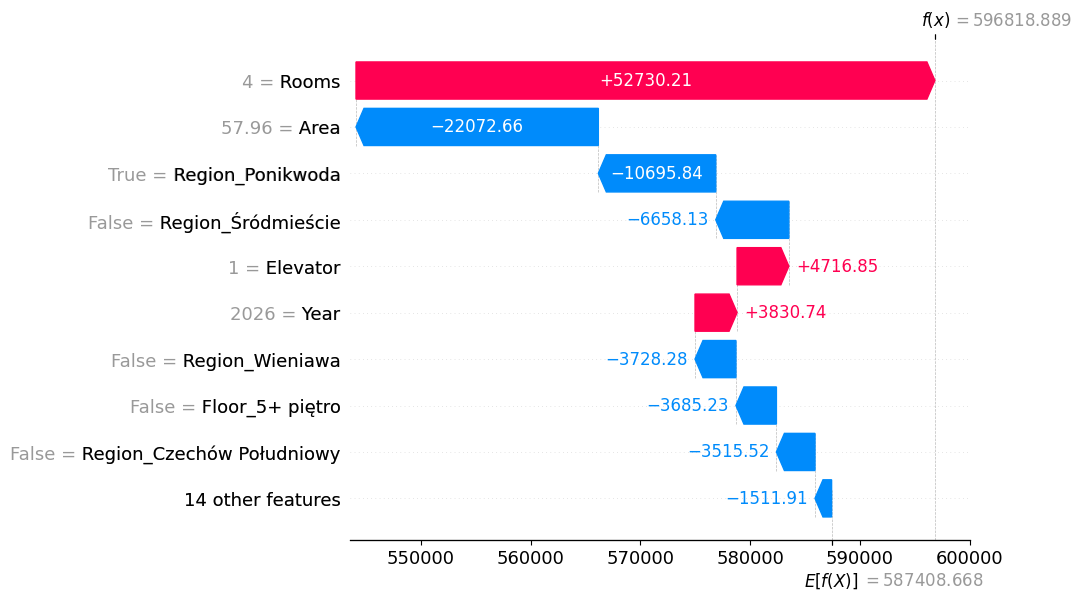

In [50]:
check_feature_importance(rf_model2, X_test_rf2,num_observations=1,random_seed=45)

This **feature importance plot** shows that **completely different features** play the biggest role in the model's decision, compared to previous feature importance plots of previous model. This confirms that **ML models function like a "black box"**, where feature contributions can vary significantly depending on the input, making interpretation complex and non-deterministic.

Now, let's handle the outliers in the dataset and remove them in case they significantly affect model performance.


### 4.4 Handling Outliers

---

**❗❗❗ Important Note: ❗❗❗**  

I researched different sources and found that **outliers can be handled either before or after splitting** the dataset. I choose to **handle them before splitting** to ensure consistency in preprocessing.  

At this stage, I don’t have a **clear goal to simply delete outliers**—instead, I want to **analyze, understand, and handle them properly** to gain deeper insights before deciding on further actions.

---

#### 4.4.1 Univariate Outlier Detection & Handling

To begin, I use the IQR method to identify outliers in Price, Area, Rooms, and Year.

In [51]:
# Columns to check for outliers
columns_to_check = ['Price', 'Area', 'Rooms', 'Year']

# Dictionary to store outlier counts
outlier_counts = {}

# Detect outliers for each column and count them
for col in columns_to_check:
    outliers = detect_outliers_iqr(data, col)
    outlier_counts[col] = len(outliers)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in Price: 97
Outliers in Area: 94
Outliers in Rooms: 51
Outliers in Year: 40


IQR method identified such large number of outliers, as I explored in the EDA section this is apartament with very large area and number of rooms and removing them could lead to difficulties of the model to predict real estate of this type, so eliminating is not the best solution. Instead of that I will apply different treatments to each variable:
-  `Year` – Some extreme values. I will apply Winsorization (1%-99%) to cap extreme values while preserving most of the distribution.
- `Price` & `Area` – These variables have a right-skewed distribution. Instead of Winsorization. 
    - Since `Price` is the target variable, I will leave it unchanged, *as previous attempts at transformation and standardization resulted in worse metrics after inverse transformation.* 
    - For `Area`, I will apply a Box-Cox transformation to normalize its distribution, followed by standardization to ensure consistent scaling.
-  `Rooms` – For  linear/non-linear algorithms I will standardize it(like with other features). For tree-based models, I stay it unchanged.

#### 4.4.2 Multivariate Outlier Detection & Handling

Unlike univariate methods, multivariate outlier detection identifies anomalous combinations of values

For this I will apply `DBSCAN` clustering to identify multivariate outliers in the dataset

Before using DBSCAN, let's choose best `eps` and `min_samples` parameters for the model. To do this, I will use the following discussion from StackOverflow: https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan/15063143#15063143

Note: As DBSCAN vulnerable to missing values and *I will impute the missing values after standardization with KNN Imputer*. For now I replace them with the median value for each column, this will not affect the main data because I do everything on a copy of the dataset.

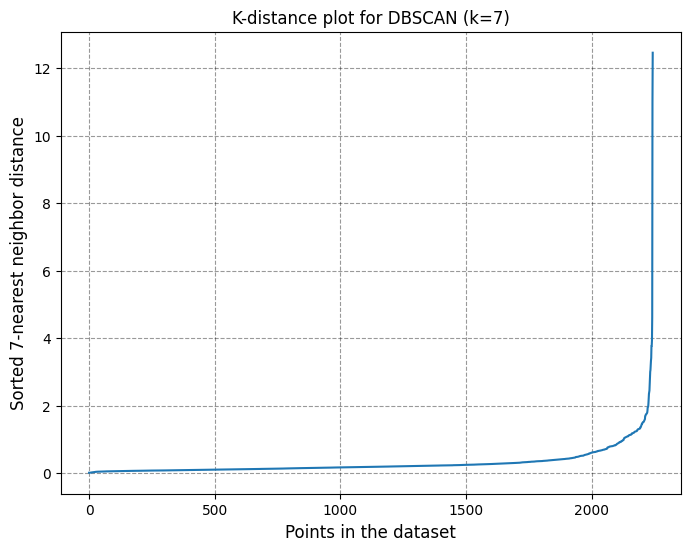

In [52]:
# Create a copy of the dataset
df_dbscan = data.copy()

# Select numerical features for DBSCAN
features_for_dbscan = ['Price', 'Area', 'Rooms', 'Year']

# Fill NaNs with the median value of each column
df_dbscan[features_for_dbscan] = df_dbscan[features_for_dbscan].fillna(df_dbscan[features_for_dbscan].median())

# Standardize the selected features (DBSCAN is sensitive to scale)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_dbscan[features_for_dbscan])

# Compute k-value using formula k = 2 * {dim(dataset)} - 1
k = 2 * scaled_features.shape[1] - 1  # k=2*number_of_features - 1

# Generate k-distance plot
get_kdist_plot(X=scaled_features, k=k)

From the plot, the optimal value for `eps` can be assumed at around 1.5

For `min_samples`, I will use general rule of thumb: `min_samples = 2 * number of features`, so in this case `min_samples = 2 * 4 = 8`

In [53]:
# Apply DBSCAN for outlier detection
dbscan = DBSCAN(eps=1.5, min_samples=8)  
df_dbscan['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

In [54]:
# Count and display number of detected outliers
outlier_count = (df_dbscan['DBSCAN_Cluster'] == -1).sum()
print(f"Total DBSCAN Outliers Detected: {outlier_count}")

Total DBSCAN Outliers Detected: 19


In [55]:
# Display the detected outliers ordered by Year column
outliers_dbscan = df_dbscan[df_dbscan['DBSCAN_Cluster'] == -1].sort_values(by='Year')

# Add a column for price per square meter
outliers_dbscan['Price_per_sqm'] = outliers_dbscan['Price'] / outliers_dbscan['Area']

# Reorder columns to place 'Price_per_sqm' in the 3rd position
cols = outliers_dbscan.columns.tolist()
cols.insert(2, cols.pop(cols.index('Price_per_sqm')))
outliers_dbscan = outliers_dbscan[cols]

# Display the updated DataFrame
print(outliers_dbscan.to_string(index=False))

    Price       Area  Price_per_sqm  Elevator  Year  Rooms     Floor             Region  DBSCAN_Cluster
1256810.0  90.459999   13893.543945         0  1815      4  1 piętro        Śródmieście              -1
1256000.0  90.459999   13884.589844         0  1815      4  1 piętro        Śródmieście              -1
 428000.0 107.000000    4000.000000         0  1910      2  1 piętro          Dziesiąta              -1
1468000.0 125.750000   11673.956055         0  1910      5  2 piętro        Śródmieście              -1
1550000.0 128.800003   12034.161133         0  1914      4  3 piętro        Śródmieście              -1
1473000.0  98.199997   15000.000000         0  1914      4  1 piętro        Śródmieście              -1
 920000.0 140.000000    6571.428711         0  1918      5  4 piętro        Śródmieście              -1
 920000.0 126.000000    7301.587402         0  1918      7  4 piętro        Śródmieście              -1
1049000.0 126.000000    8325.396484         0  1927      4  1 pi

After analyzing the DBSCAN outliers, I identified the following key patterns:
- Mostly very old houses.
- Some houses with extremely low price per square meter
- Few apartments

Appartment with missing floor value, could be change similar to other apartments with 10 rooms on 1 piętro.

In [56]:
data.loc[(data['Region'] == 'Wieniawa') & (data['Price'] == 1940000.0), 'Floor'] = '1 piętro'

Additionally visualize them in 3D to see how far these points are from other data points in multidimensional space. This helps us understand the distribution and severity of anomalies in the dataset.

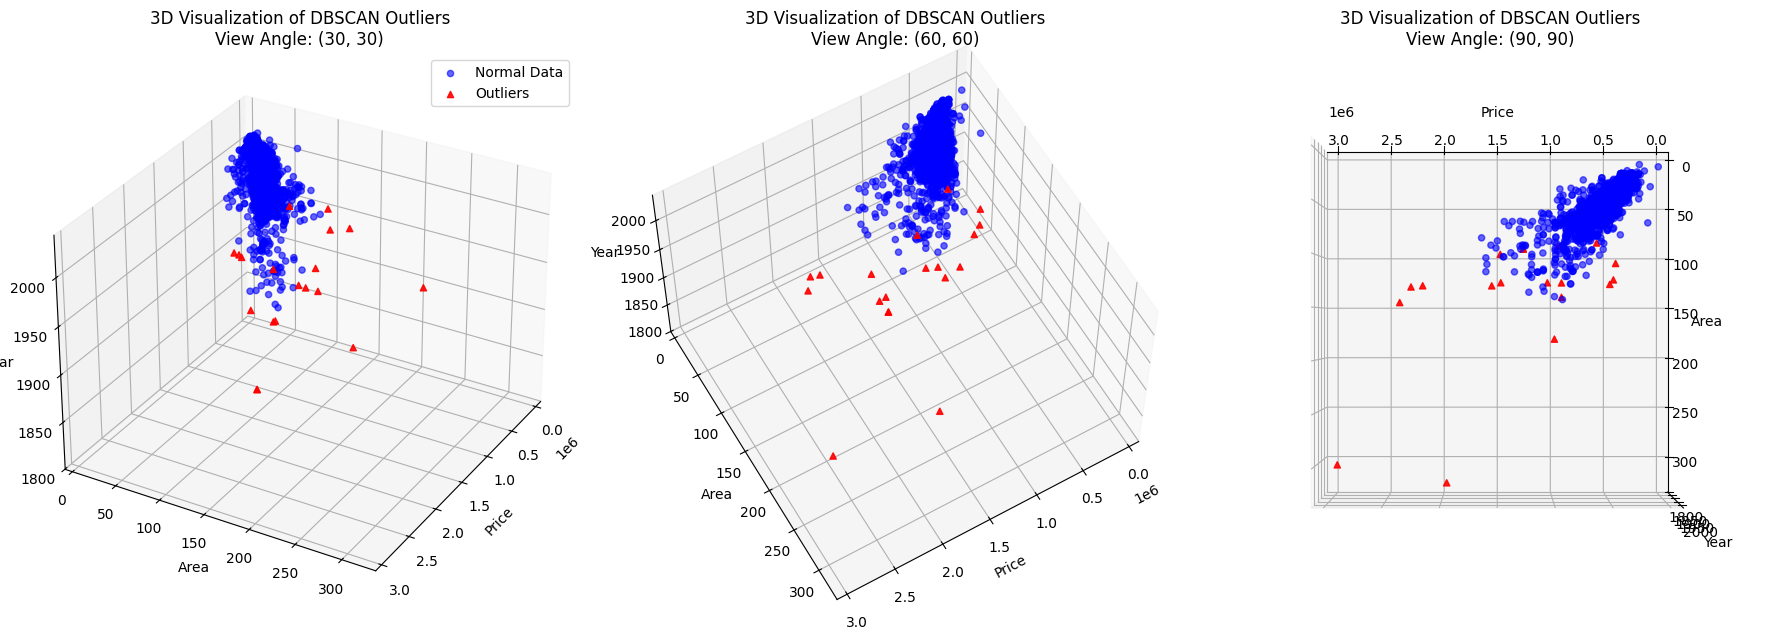

In [57]:
# Prepare Data for Visualization
fig = plt.figure(figsize=(18, 6))

# Extract normal points & outliers
normal_points = df_dbscan[df_dbscan['DBSCAN_Cluster'] != -1]
outlier_points = df_dbscan[df_dbscan['DBSCAN_Cluster'] == -1]

# Define angles for different views
angles = [(30, 30), (60, 60), (90, 90)]

for i, angle in enumerate(angles, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    
    # Scatter plot
    ax.scatter(normal_points['Price'], normal_points['Area'], normal_points['Year'], c='blue', label='Normal Data', alpha=0.6)
    ax.scatter(outlier_points['Price'], outlier_points['Area'], outlier_points['Year'], c='red', label='Outliers', alpha=0.9, marker='^')
    
    # Labels & Legend
    ax.set_xlabel("Price")
    ax.set_ylabel("Area")
    ax.set_zlabel("Year")
    ax.set_title(f"3D Visualization of DBSCAN Outliers\nView Angle: {angle}")
    ax.view_init(elev=angle[0], azim=angle[1])
    if i == 1:
        ax.legend()

plt.tight_layout()
plt.show()

The 3D plot shows outliers, but since the dataset has more features, this view is limited. These few but extreme cases could mislead the model, and synthetic filling might add false patterns.

So I will try to build a Random Forest model with that outliers and SMOGN technique to handle imbalanced data. Then I evaluate the model performance and compare it with the previous version.

#### 4.4.3 Build RF model with SNOGN

Since SMOGN is sensitive to missing values, I'll impute them (median for numerical, mode for categorical), one-hot encode categorical variables, and scale numerical features. Then, I'll split the data, apply SMOGN to the training set to handle price outliers, and inverse transform the target variable. Finally, I'll tune hyperparameters with RandomizedSearchCV for optimal Random Forest performance and evaluate the model on the test set.

In [58]:
# Create a copy of the dataset for RF3 model
data_rf3 = data.copy()

# Handle missing values
data_rf3['Year'] = data_rf3['Year'].fillna(data_rf3['Year'].median())
data_rf3['Floor'] = data_rf3['Floor'].fillna(data_rf3['Floor'].mode()[0])  # Mode for categorical

# One-hot encode categorical features
data_rf3 = pd.get_dummies(data_rf3, columns=['Floor', 'Region'], drop_first=True, dtype='int32')

# Define features and target
features = data_rf3.drop('Price', axis=1)
target = data_rf3['Price']

# Create separate scalers
scaler_features = MinMaxScaler()
scaler_price = MinMaxScaler()

# Scale only numerical features except Price
num_features = ['Area', 'Year', 'Rooms']
features[num_features] = scaler_features.fit_transform(features[num_features])

# Scale Price separately
target_scaled = scaler_price.fit_transform(target.values.reshape(-1, 1)).flatten()

# Train-test split
X_train_rf3, X_test_rf3, y_train_rf3, y_test_rf3 = train_test_split(
    features, target_scaled, test_size=0.2, random_state=42
)

# Combine train features and target for SMOGN processing
train_rf3 = X_train_rf3.copy()
train_rf3['Price'] = y_train_rf3

# Reset index before applying SMOGN
train_rf3 = train_rf3.reset_index(drop=True)

# Ensure no missing values before SMOGN
train_rf3 = train_rf3.fillna(train_rf3.median())

# Apply SMOGN to the cleaned dataset
train_rf3_smogn = smogn.smoter( 
    data=train_rf3,
    y='Price',
    pert=0.1,  # Adjust Gaussian noise level
    samp_method='balance'  # Use 'balance' instead of 'extreme' for better distribution
)

# Reset index again to avoid index mismatches
train_rf3_smogn = train_rf3_smogn.reset_index(drop=True)

# Separate features and target again after SMOGN
X_train_rf3_smogn = train_rf3_smogn.drop('Price', axis=1)
y_train_rf3_smogn = train_rf3_smogn['Price']

# Inverse transform Price using its own scaler
y_train_rf3_smogn = scaler_price.inverse_transform(y_train_rf3_smogn.values.reshape(-1, 1)).flatten()

# Define hyperparameter grid for Random Forest tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform hyperparameter tuning
rf_grid = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    n_iter=10,
    n_jobs=-1
)

# Train the best Random Forest model found
rf_grid.fit(X_train_rf3_smogn, y_train_rf3_smogn)
best_rf_model = rf_grid.best_estimator_

# Predict on test set
y_pred_rf3 = best_rf_model.predict(X_test_rf3)

# Inverse transform y_test_rf3 before evaluation
y_test_rf3 = scaler_price.inverse_transform(y_test_rf3.reshape(-1, 1)).flatten()

# Evaluate the model
rf3_r2, rf3_mae, rf3_mse, rf3_rmse, rf3_mape, rf3_rmsle = evaluate_model(y_test_rf3, y_pred_rf3)
print(f"R^2: {rf3_r2:.4f}")
print(f"MAE: {rf3_mae:.2f}")       
print(f"RMSE: {rf3_rmse:.2f}")
print(f"MAPE: {rf3_mape:.2f}")
print(f"RMSLE: {rf3_rmsle:.4f}")

r_index: 100%|##########| 114/114 [00:00<00:00, 753.61it/s]


R^2: 0.7731
MAE: 63419.62
RMSE: 94429.94
MAPE: 10.53
RMSLE: 0.1324


Such harder and complex model with SMOGN technique and outliers handling, achieved worse results than the previous version model. So for future deeper analysis, I will write a copy of that dataset to a variable data_smogn and continue with the previous version of the dataset, by removing outliers.

In [59]:
data_smogn = data.copy(deep=True)

**Why Remove These Outliers?**
-  Small number of cases (only 19)
-  Synthetic filling (e.g., SMOGN) could introduce misleading data
-  Retaining them could bias the model
-  We already experimented with them and achieved worse results

Achieving worse results initially isn’t necessarily bad because the model is exposed to more diverse data and patterns, which can help it better generalize to extreme cases. This could lead to improved predictions on outliers or rare cases, which I plan to remove later. As my goal in this project is EXPERIMENT and find approaches to improve the model performance, using different techniques and methods, I will delete these outliers.

So delete that outliers from the main dataset.

In [60]:
# Identify outliers (DBSCAN-flagged as -1)
outlier_indices = df_dbscan[df_dbscan['DBSCAN_Cluster'] == -1].index

# Remove outliers from the main dataset
data = data.drop(index=outlier_indices)

Additionally let's once more check univariate outliers to verify if their number decreased.

In [61]:
# Columns to check for outliers
columns_to_check = ['Price', 'Area', 'Rooms', 'Year']

# Dictionary to store outlier counts
outlier_counts = {}

# Detect outliers for each column and count them
for col in columns_to_check:
    outliers = detect_outliers_iqr(data, col)
    outlier_counts[col] = len(outliers)
    print(f"Outliers in {col}: {len(outliers)}")

Outliers in Price: 87
Outliers in Area: 80
Outliers in Rooms: 41
Outliers in Year: 36


Number of outliers decreased for each variable enough well, including the fact that I deleted only 19 observations.

### 4.5 Train-Test-Validation Split

As I will build various machine learning/deep learning models, I will split the dataset into training, validation, and test sets, I will use 70-15-15 split ratio. \
**It is very important to make split before any data transformation to avoid data leakage.**\
https://datascience.stackexchange.com/questions/53138/which-comes-first-multiple-imputation-splitting-into-train-test-or-standardiz
> Always split before you do any data pre-processing. Performing pre-processing before splitting will mean that information from your test set will be present during training, causing a data leak.

Additionally, some models require standardization, while others don't. 
- Linear models & Neural Networks: Require raw Price, Box-Cox transformation Area and standardization for numerical features.
- Tree-based models (Random Forest, XGBoost, etc.): Work best with raw Price, Box-Cox transformed Area, and unstandardized features.

In [62]:
data.dtypes

Price       float32
Area        float32
Elevator      int32
Year          Int32
Rooms         int32
Floor        object
Region       object
dtype: object

In [63]:
# Create separate datasets for tree-based and linear models
data_tree = data.copy(deep=True)
data_linear = data.copy(deep=True)

# Define features (X) and target (y)
X_tree = data_tree.drop('Price', axis=1)
y_tree = data_tree['Price']

X_linear = data_linear.drop('Price', axis=1)
y_linear = data_linear['Price']

# Train-Test-Validation split (70-15-15 ratio)
X_train_tree, X_temp_tree, y_train_tree, y_temp_tree = train_test_split(
    X_tree, y_tree, test_size=0.3, random_state=42)

X_val_tree, X_test_tree, y_val_tree, y_test_tree = train_test_split(
    X_temp_tree, y_temp_tree, test_size=0.5, random_state=42)

X_train_linear, X_temp_linear, y_train_linear, y_temp_linear = train_test_split(
    X_linear, y_linear, test_size=0.3, random_state=42)

X_val_linear, X_test_linear, y_val_linear, y_test_linear = train_test_split(
    X_temp_linear, y_temp_linear, test_size=0.5, random_state=42)

# Display dataset sizes
split_summary = {
    "Dataset": ["Training", "Validation", "Test"],
    "Tree-Based (X)": [X_train_tree.shape[0], X_val_tree.shape[0], X_test_tree.shape[0]],
    "Tree-Based (y)": [y_train_tree.shape[0], y_val_tree.shape[0], y_test_tree.shape[0]],
    "Linear-Based (X)": [X_train_linear.shape[0], X_val_linear.shape[0], X_test_linear.shape[0]],
    "Linear-Based (y)": [y_train_linear.shape[0], y_val_linear.shape[0], y_test_linear.shape[0]]
}

split_summary

{'Dataset': ['Training', 'Validation', 'Test'],
 'Tree-Based (X)': [1556, 334, 334],
 'Tree-Based (y)': [1556, 334, 334],
 'Linear-Based (X)': [1556, 334, 334],
 'Linear-Based (y)': [1556, 334, 334]}

Train test validation split is done, now let's move to the next step.

### 4.6 Feature Transformation

#### 4.6.1 Tree Based Data Transformation

For tree-based models, I will apply the **Box-Cox transformation** to the `Area` feature to **normalize its distribution** and **winsorize the `Year` feature** to handle extreme values. Other transformations will be applied **specifically for each model**.  

At this stage, I **will not apply one-hot encoding**, as some algorithms (e.g., **CatBoost**) perform better with **label encoding**. Since I couldn't find conclusive research on which encoding works best for tree-based models, I will **experiment with both approaches** for some algorithms. 

Apply Box-Cox transformation to the `Area` feature. Of course, for validation and test sets, I will use the lambda value calculated on the training set.

In [64]:
# Copy datasets for transformation
X_train_tree_transformed = X_train_tree.copy()
X_val_tree_transformed = X_val_tree.copy()
X_test_tree_transformed = X_test_tree.copy()

# Apply Box-Cox transformation and store lambda
X_train_tree_transformed['Area'], area_lambda = stats.boxcox(X_train_tree_transformed['Area'])

# Apply the same lambda to validation and test sets
X_val_tree_transformed['Area'] = stats.boxcox(X_val_tree_transformed['Area'], lmbda=area_lambda)
X_test_tree_transformed['Area'] = stats.boxcox(X_test_tree_transformed['Area'], lmbda=area_lambda)

Additionally check the lambda area value

In [65]:
# Check transformation effect
print(f"Box-Cox Lambda for Area: {area_lambda}")

Box-Cox Lambda for Area: 0.009736520232480972


The **Box-Cox lambda (0.0097)** indicates a transformation close to log transformation

Let's check how changed the distribution of the `Area` feature after Box-Cox transformation.

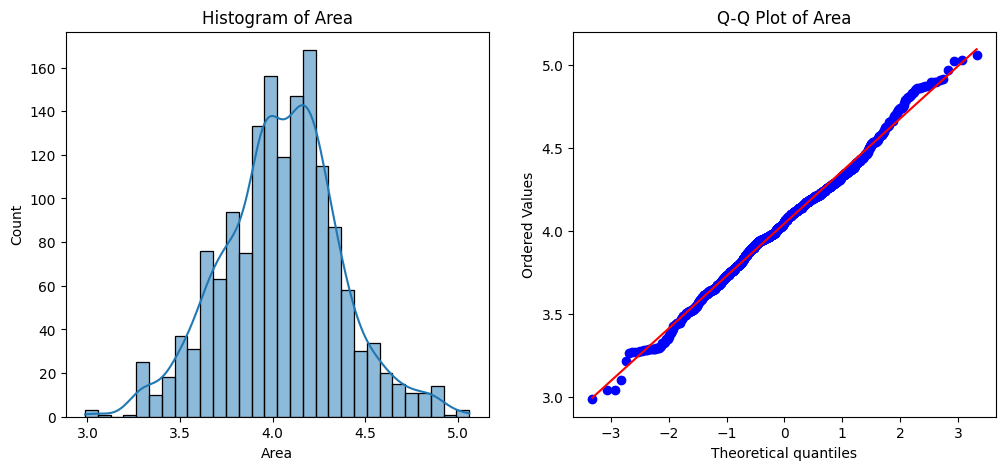

Normality Tests for Area:
  Shapiro-Wilk Test: W=0.9951, p-value=0.0001
  D'Agostino's K² Test: Stat=5.2042, p-value=0.0741
  Reject null hypothesis for Shapiro-Wilk Test at alpha=0.05
  Fail to reject null hypothesis for D'Agostino's K² Test at alpha=0.05
--------------------------------------------------


In [66]:
cols = ["Area"]
check_normality(X_train_tree_transformed, cols)

After the Box-Cox transformation, the `Area` feature exhibits a distribution closer to normality. The **Shapiro-Wilk test rejected the null hypothesis of normality**, while **D'Agostino's K² test failed to reject it**, suggesting improved normality. The **Q-Q plot shows that the transformed data points align more closely with the diagonal**, further indicating a more normally distributed feature.

Apply Winsorization to the `Year` feature.

I make a box plot of the `Year` column before and after winsorization to ensure that extreme values are capped.

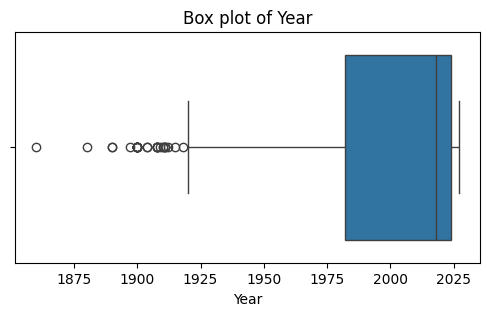

In [67]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=X_train_tree_transformed['Year'])
plt.title('Box plot of Year')
plt.xlabel('Year')
plt.show()

In [68]:
# Apply Winsorization to the training set and get limits
X_train_tree_transformed['Year'], year_lower, year_upper = winsorize_series(X_train_tree_transformed['Year'])

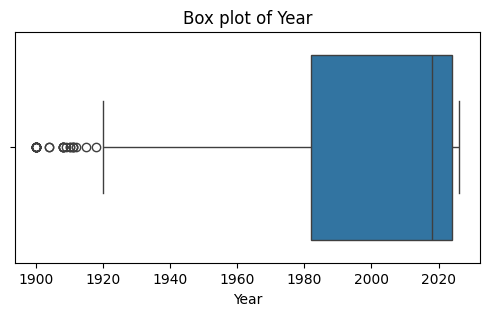

In [69]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=X_train_tree_transformed['Year'])
plt.title('Box plot of Year')
plt.xlabel('Year')
plt.show()

Winsorization made successfully.

This is also important to make Winsorization of test and validation sets and like with Box-Cox transformation, I will use the values calculated on the training set.
Source: https://stats.stackexchange.com/questions/350487/is-winsorization-performed-on-test-data-as-well
> it is common practice to apply Winsorization to test data as well.

> Before applying the model to test data, you have to apply Winsorization to test data as well (using the values saved from train data).

In [70]:
# Apply the same limits to validation and test sets
X_test_tree_transformed['Year'] = X_test_tree_transformed['Year'].clip(lower=year_lower, upper=year_upper).astype(X_test_tree_transformed['Year'].dtype)
X_val_tree_transformed['Year'] = X_val_tree_transformed['Year'].clip(lower=year_lower, upper=year_upper).astype(X_val_tree_transformed['Year'].dtype)

In this step I don't make standardization as I read [here](https://builtin.com/data-science/when-and-why-standardize-your-data)
> Algorithms such as decision trees, random forests and gradient boosting are not sensitive to the magnitude of variables. So standardization is not needed before fitting these kinds of models.

Of course the best way is to build few models and compare them, instead of always trust resources from the internet, because best model is the one that gives the best metrics.

#### 4.6.2 Linear Models Data Transformation

For linear models and Neural Networks, I will apply the following transformations:
- Box-Cox transformation to the `Area` feature to normalize its distribution.
- Winsorization to the `Year` feature to handle extreme values.
- Standardization to ensure consistent scaling across features.

Firstly make Box-Cox transformation to the `Area` feature.

In [71]:
# Copy datasets for transformation
X_train_linear_transformed = X_train_linear.copy()
X_val_linear_transformed = X_val_linear.copy()
X_test_linear_transformed = X_test_linear.copy()

# Apply Box-Cox transformation and store lambda
X_train_linear_transformed['Area'], area_lambda = stats.boxcox(X_train_linear_transformed['Area']) # Lambda will be the same as for tree-based

# Apply the same lambda to validation and test sets
X_val_linear_transformed['Area'] = stats.boxcox(X_val_linear_transformed['Area'], lmbda=area_lambda)
X_test_linear_transformed['Area'] = stats.boxcox(X_test_linear_transformed['Area'], lmbda=area_lambda)

Now apply Winsorization to the `Year` feature.

In [72]:
# Apply Winsorization to the training set and get limits
X_train_linear_transformed['Year'], year_lower, year_upper = winsorize_series(X_train_linear_transformed['Year'])

# Apply the same limits to validation and test sets
X_val_linear_transformed['Year'] = X_val_linear_transformed['Year'].clip(lower=year_lower, upper=year_upper).astype(X_val_linear_transformed['Year'].dtype)
X_test_linear_transformed['Year'] = X_test_linear_transformed['Year'].clip(lower=year_lower, upper=year_upper).astype(X_test_linear_transformed['Year'].dtype)

Now I will make standardization of the training set and then apply it to the validation and test sets.

Like with Box-Cox transformation and Winsorization, for standardization of test and validation sets, I will use the values calculated on the training set.

In [73]:
# Select numerical columns for standardization
num_cols = ['Area', 'Elevator', 'Year', 'Rooms']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_linear_transformed[num_cols] = scaler.fit_transform(X_train_linear_transformed[num_cols])

# Apply the same scaler to validation and test sets
X_val_linear_transformed[num_cols] = scaler.transform(X_val_linear_transformed[num_cols])
X_test_linear_transformed[num_cols] = scaler.transform(X_test_linear_transformed[num_cols])

Look on the dataset after transformations.

In [74]:
X_train_linear_transformed.head()

,Area,Elevator,Year,Rooms,Floor,Region
2217,-0.252426,-1.018160,NaN,0.359605,1 piętro,Czuby Północne
849,0.130607,0.982164,0.742415,0.359605,1 piętro,Wieniawa
2497,1.026662,0.982164,0.777270,1.532657,3 piętro,Ponikwoda
406,-2.203408,-1.018160,NaN,-1.986498,parter,Other
1769,1.407882,0.982164,0.289304,1.532657,3 piętro,Sławin


Good

### 4.7 Handling Missing Values

I already wrote in 2.5 that that for missing values in `Year` and `Floor`, I will use a `KNN Imputer`, but after standardization, because KNN imputation requires standardization first due to how distance calculations work.

So now I could make KNN imputation for the `data_tree` and `data_linear` datasets.

#### 4.7.1 KNN Imputation for Tree-Based Models

Since **KNN Imputer** only works with numerical data, I will temporarily encode `Floor` as numbers, impute missing values, and then convert it back to its original categorical format.

As other transformation techniques to avoid data leakage I will use the imputer values calculated on the training set for validation and test sets. 

In [75]:
# Define the ordered mapping for Floor (assuming 'parter' is ground floor)
floor_mapping = {
    'parter': 0,
    '1 piętro': 1,
    '2 piętro': 2,
    '3 piętro': 3,
    '4 piętro': 4,
    '5+ piętro': 5,  
    np.nan: np.nan  # Keep NaNs for imputation
}

# Encode Floor using the defined mapping
X_train_tree_transformed['Floor'] = X_train_tree_transformed['Floor'].map(floor_mapping)
X_val_tree_transformed['Floor'] = X_val_tree_transformed['Floor'].map(floor_mapping)
X_test_tree_transformed['Floor'] = X_test_tree_transformed['Floor'].map(floor_mapping)

# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)

# Select numerical columns including Floor (but NOT Region)
num_cols = ['Area', 'Elevator', 'Year', 'Rooms', 'Floor']

# Fit on training data and transform
X_train_tree_transformed[num_cols] = knn_imputer.fit_transform(X_train_tree_transformed[num_cols])

# Apply the trained imputer to validation and test sets
X_val_tree_transformed[num_cols] = knn_imputer.transform(X_val_tree_transformed[num_cols])
X_test_tree_transformed[num_cols] = knn_imputer.transform(X_test_tree_transformed[num_cols])

# Round Floor values after imputation to ensure integers
X_train_tree_transformed['Floor'] = np.round(X_train_tree_transformed['Floor']).astype(int)
X_val_tree_transformed['Floor'] = np.round(X_val_tree_transformed['Floor']).astype(int)
X_test_tree_transformed['Floor'] = np.round(X_test_tree_transformed['Floor']).astype(int)

# Reverse map numerical values back to original categories
reverse_floor_mapping = {v: k for k, v in floor_mapping.items()}  # Swap keys and values

X_train_tree_transformed['Floor'] = X_train_tree_transformed['Floor'].map(reverse_floor_mapping)
X_val_tree_transformed['Floor'] = X_val_tree_transformed['Floor'].map(reverse_floor_mapping)
X_test_tree_transformed['Floor'] = X_test_tree_transformed['Floor'].map(reverse_floor_mapping)

To choose better `n_neighbors` value for KNN Imputer, I will build Random Forest model with different `n_neighbors` values and choose the best one. 


The best `n_neighbors` value is the one that gives the best model performance.

#### 4.7.2 Build Random Forest Model with KNN Imputation

In [76]:
X_train_tree_transformed_fr4 = X_train_tree_transformed.copy()

region_counts = X_train_tree_transformed_fr4['Region'].value_counts()
total_count = len(X_train_tree_transformed_fr4)
class_weights = {region: total_count / count for region, count in region_counts.items()}

# Create a new column to store sample weights before one-hot encoding
X_train_tree_transformed_fr4['Sample_Weight'] = X_train_tree_transformed_fr4['Region'].map(class_weights)

# One-hot encode 'Floor' and 'Region' columns
X_train_tree_transformed_fr4 = pd.get_dummies(X_train_tree_transformed_fr4, columns=['Floor', 'Region'], dtype='int32')

# Define features and target
features = X_train_tree_transformed_fr4.drop(['Sample_Weight'], axis=1)  # Exclude sample weight from features
target = y_train_tree
sample_weights = X_train_tree_transformed_fr4['Sample_Weight']  # Keep sample weights separate

# Initialize and train the Random Forest model with sample weights
rf_model4 = RandomForestRegressor(n_estimators=100, 
                                  random_state=42,
                                  max_features='sqrt')

rf_model4.fit(features, 
              target, 
              sample_weight=sample_weights)

# Prepare test set for prediction
X_test_tree_transformed_rf4 = X_test_tree_transformed.copy()
X_test_tree_transformed_rf4 = pd.get_dummies(X_test_tree_transformed_rf4, columns=['Floor', 'Region'], dtype='int32')

# Predict on test set
y_pred_rf4 = rf_model4.predict(X_test_tree_transformed_rf4)

# Evaluate the model
rf4_r2, rf4_mae, rf4_mse, rf4_rmse, rf4_mape, rf4_rmsle = evaluate_model(y_test_tree, y_pred_rf4)
print(f"R^2: {rf4_r2:.4f}")
print(f"MAE: {rf4_mae:.2f}")       
print(f"RMSE: {rf4_rmse:.2f}")
print(f"MAPE: {rf4_mape:.2f}")
print(f"RMSLE: {rf4_rmsle:.4f}")

R^2: 0.7986
MAE: 51465.50
RMSE: 77410.92
MAPE: 8.94
RMSLE: 0.1235


With default `n_neighbors = 5` model achieved the best results, so I will use this value for KNN Imputer. 

**After the transformations and imputation**, the following interesting situation can be observed in comparing with Random Forest model from `4.3`:
- R^2 decrease from 82% to 80%
- MAE increase from 50,000 to 51,500
- RMSE decrease from 83,500 to 77,500

From these results, we can conclude that the **model makes lighter mistakes** in larger price predictions while becoming slightly less precise overall.

#### 4.7.3 KNN Imputation for Linear Models

Like for tree-based models, I will impute missing values in the `data_linear` dataset using the KNN Imputer with `n_neighbors = 5`, as it gave the best results for the Random Forest model.

In [77]:
# Encode Floor using the defined mapping
X_train_linear_transformed['Floor'] = X_train_linear_transformed['Floor'].map(floor_mapping)
X_val_linear_transformed['Floor'] = X_val_linear_transformed['Floor'].map(floor_mapping)
X_test_linear_transformed['Floor'] = X_test_linear_transformed['Floor'].map(floor_mapping)

# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5) # Use 5 as before showed good results

# Select numerical columns including Floor (but NOT Region)
num_cols = ['Area', 'Elevator', 'Year', 'Rooms', 'Floor']

# Fit on training data and transform
X_train_linear_transformed[num_cols] = knn_imputer.fit_transform(X_train_linear_transformed[num_cols])

# Apply the trained imputer to validation and test sets
X_val_linear_transformed[num_cols] = knn_imputer.transform(X_val_linear_transformed[num_cols])
X_test_linear_transformed[num_cols] = knn_imputer.transform(X_test_linear_transformed[num_cols])

# Round Floor values after imputation to ensure integers
X_train_linear_transformed['Floor'] = np.round(X_train_linear_transformed['Floor']).astype(int)
X_val_linear_transformed['Floor'] = np.round(X_val_linear_transformed['Floor']).astype(int)
X_test_linear_transformed['Floor'] = np.round(X_test_linear_transformed['Floor']).astype(int)

# Reverse map numerical values back to original categories
reverse_floor_mapping = {v: k for k, v in floor_mapping.items()}  # Swap keys and values

X_train_linear_transformed['Floor'] = X_train_linear_transformed['Floor'].map(reverse_floor_mapping)
X_val_linear_transformed['Floor'] = X_val_linear_transformed['Floor'].map(reverse_floor_mapping)
X_test_linear_transformed['Floor'] = X_test_linear_transformed['Floor'].map(reverse_floor_mapping)

### 4.8 One-Hot Encoding for Categorical Features

Once imputation is done, I will apply one-hot encoding to categorical features

But as I discovered from next sources, tree based methods doesn't require one-hot encoding and works good with label encoding features, while linear models and neural networks require one-hot encoding, as with them works better.

---

[why tree-based model do not need one-hot encoding](https://medium.com/data-science-at-microsoft/categorically-dont-explode-encode-dd623b565ce3#:~:text=Because%20tree%20models%20work%20by,hot%2Dencoding%20handed%20to%20it.)

>Because tree models work by chopping up a given feature into partitions, a tree model is capable of carving the data up into segments that are defined by the categorical vector without having a one-hot-encoding handed to it.

[One Hot Encoding vs Label Encoding](https://medium.com/biased-algorithms/one-hot-encoding-vs-label-encoding-28aee12b3984)
> Logistic Regression: One hot encoding is essential because this algorithm treats categorical variables as independent.

> Neural Networks: Neural nets love one hot encoding because it simplifies the input, letting the network focus on patterns in numerical data.

---

However, there are no strict rules on which encoding method to use—the best approach is the one that yields the best model performance.

So in code below I will one-hot encode the `data_linear` dataset. For now I don't do anything with `data_tree` dataset, because I will experiment with different encoding methods in the next steps. 

In [78]:
X_train_linear_transformed = pd.get_dummies(X_train_linear_transformed, columns=['Floor', 'Region'], dtype='int32')
X_val_linear_transformed = pd.get_dummies(X_val_linear_transformed, columns=['Floor', 'Region'], dtype='int32')
X_test_linear_transformed = pd.get_dummies(X_test_linear_transformed, columns=['Floor', 'Region'], dtype='int32')

## 5. Build Machine Learning Models

Okay I will start from linear models, then move to tree-based models.

### 5.1 Linear Regression

In [79]:
# Initialize Linear Regression model
lr_model = LinearRegression()

# Train the model on training data
lr_model.fit(X_train_linear_transformed, y_train_linear)

# Predict on the test set
y_pred_linear = lr_model.predict(X_test_linear_transformed)

# Evaluate the model using your existing function
lr_r2, lr_mae, lr_mse, lr_rmse, lr_mape, lr_rmsle = evaluate_model(y_test_linear, y_pred_linear)

# Print results
print(f"R^2: {lr_r2:.4f}")
print(f"MAE: {lr_mae:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAPE: {lr_mape:.2f}")
print(f"RMSLE: {lr_rmsle:.4f}")


R^2: 0.6811
MAE: 70462.11
RMSE: 97410.94
MAPE: 12.55
RMSLE: 0.2005


Linear regression performed poorly due to the complex, non-linear relationships in the housing data, which it couldn't capture effectively.

### 5.2 Elastic Net Regression

Elastic Net improves upon Linear Regression by combining L1 (Lasso) and L2 (Ridge) regularization, which helps reduce overfitting, handle multicollinearity, and select important features.

Since its performance depends on alpha (regularization strength) and l1_ratio (balance between L1 and L2), I use GridSearchCV to find the best combination. 

In [80]:
# Define the parameter grid for Elastic Net
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]  # Balance between L1 (Lasso) and L2 (Ridge)
}

# Initialize Elastic Net model
elastic_net = ElasticNet(max_iter=5000)

# Grid Search CV
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_linear_transformed, y_train_linear)

# Get best model from Grid Search
best_elastic_model = grid_search.best_estimator_

# Predict on test set
y_pred_elastic = best_elastic_model.predict(X_test_linear_transformed)

# Evaluate the model using your existing function
elastic_r2, elastic_mae, elastic_mse, elastic_rmse, elastic_mape, elastic_rmsle = evaluate_model(y_test_linear, y_pred_elastic)

# Print best hyperparameters
print(f"Best Elastic Net parameters: {grid_search.best_params_}")

# Print evaluation results
print(f"R^2: {elastic_r2:.4f}")
print(f"MAE: {elastic_mae:.2f}")
print(f"RMSE: {elastic_rmse:.2f}")
print(f"MAPE: {elastic_mape:.2f}")
print(f"RMSLE: {elastic_rmsle:.4f}")

Best Elastic Net parameters: {'alpha': 100, 'l1_ratio': 1}
R^2: 0.6827
MAE: 70255.33
RMSE: 97161.38
MAPE: 12.51
RMSLE: 0.1996


**Elastic Net regression** performed few better than Linear Regression, but this results are too weak compared to Random Forest model, which I built in the previous steps.

### 5.3 Support Vector Regression

Now let's try **Support Vector Regression (SVR)**, which can capture complex relationships in the data and handle non-linear patterns.

In [81]:
# Define parameter grid for SVR
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}

# Initialize SVR model
svr = SVR()

# Grid Search CV
grid_search_svr = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_svr.fit(X_train_linear_transformed, y_train_linear)

# Get best model from Grid Search
best_svr_model = grid_search_svr.best_estimator_

# Predict on test set
y_pred_svr = best_svr_model.predict(X_test_linear_transformed)

# Evaluate the model using your existing function
svr_r2, svr_mae, svr_mse, svr_rmse, svr_mape, svr_rmsle = evaluate_model(y_test_linear, y_pred_svr)

# Print best hyperparameters
print(f"Best SVR parameters: {grid_search_svr.best_params_}")

# Print evaluation results
print(f"R^2: {svr_r2:.4f}")
print(f"MAE: {svr_mae:.2f}")
print(f"RMSE: {svr_rmse:.2f}")
print(f"MAPE: {svr_mape:.2f}")
print(f"RMSLE: {svr_rmsle:.4f}")

Best SVR parameters: {'C': 1000, 'degree': 2, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
R^2: 0.6667
MAE: 64101.04
RMSE: 99576.62
MAPE: 10.64
RMSLE: 0.1517


**Support Vector Regression (SVR)** performed slightly better than **Linear and Elastic Net Regression** in terms of **MAE**, achieving a significantly lower error. However, it resulted in **higher RMSE and a lower R²**, indicating greater variance in predictions.

Linear models struggled due to the **non-linear and complex relationships** in housing data. 

---

Since **linear models couldn't handle the complexity** of the data, we now shift to **tree-based models**. These models **handle non-linearity, interactions, and feature importance better**, making them well-suited for house price prediction. 

### 5.4 Decision Tree Regressor

I will train a **Decision Tree Regressor** with LableEncoding of categorical features and tune hyperparameters with GridSearchCV to find the best model performance.

In [82]:
# Make a copy of tree-based dataset for Decision Tree model
X_train_tree_dt = X_train_tree_transformed.copy()
X_val_tree_dt = X_val_tree_transformed.copy()
X_test_tree_dt = X_test_tree_transformed.copy()

# Label encode categorical columns ('Floor' and 'Region')
label_encoders = {}

for col in ['Floor', 'Region']:
    le = LabelEncoder()
    X_train_tree_dt[col] = le.fit_transform(X_train_tree_dt[col])
    X_val_tree_dt[col] = le.transform(X_val_tree_dt[col])
    X_test_tree_dt[col] = le.transform(X_test_tree_dt[col])
    label_encoders[col] = le  # Store encoders for later use if needed

# Define parameter grid for Decision Tree
param_grid = {
    'max_depth': [5, 10, 15, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],  # Minimum samples in a leaf node
    'criterion': ['squared_error', 'friedman_mse']  # Loss function
}

# Initialize Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Grid Search CV
grid_search_dt = GridSearchCV(dt_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_dt.fit(X_train_tree_dt, y_train_tree)

# Get the best Decision Tree model
best_dt_model = grid_search_dt.best_estimator_

# Predict on the test set
y_pred_dt = best_dt_model.predict(X_test_tree_dt)

# Evaluate the model using your existing function
dt_r2, dt_mae, dt_mse, dt_rmse, dt_mape, dt_rmsle = evaluate_model(y_test_tree, y_pred_dt)

# Print best hyperparameters
print(f"Best Decision Tree parameters: {grid_search_dt.best_params_}")

# Print evaluation results
print(f"R^2: {dt_r2:.4f}")
print(f"MAE: {dt_mae:.2f}")
print(f"RMSE: {dt_rmse:.2f}")
print(f"MAPE: {dt_mape:.2f}")
print(f"RMSLE: {dt_rmsle:.4f}")


Best Decision Tree parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
R^2: 0.6813
MAE: 68600.51
RMSE: 97373.72
MAPE: 11.98
RMSLE: 0.1566


The **Decision Tree Regressor** performed similar to the linear models, so now let's try **Random Forest** to improve performance and capture more complex patterns.

### 5.5 Random Forest Regressor

As I built Random Forest model before and it performed well, now I want to try several different approaches and compare with what model will perform the best.

So I want to compare Random Forest model with:
- **Label Encoding** for categorical features
- **One-Hot Encoding** for categorical features
- **One-Hot Encoding** for categorical features and **weighted samples**

For the training I will use functions `preprocess_data` and `train_evaluate` from the `helper_functions.py` file, to make the notebook cleaner.\
For tuning hyperparameters I will use global variable `PARAM_GRID`, which I also moved to the `helper_functions.py` file.

In [83]:
# Train and evaluate models
models = {
    "RF-LE": preprocess_data("LE", X_train_tree_transformed, X_val_tree_transformed, X_test_tree_transformed),
    "RF-OHE": preprocess_data("OHE", X_train_tree_transformed, X_val_tree_transformed, X_test_tree_transformed),
    "RF-OHE-Weighted": preprocess_data("OHE-W", X_train_tree_transformed, X_val_tree_transformed, X_test_tree_transformed)
}

results, best_params = {}, {}

for name, (X_train, X_test, sample_weight) in models.items():
    results[name], best_params[name] = train_evaluate(X_train, X_test, y_train_tree, y_test_tree, sample_weight, PARAM_GRID)

# Convert results to DataFrame & Display
results_df = pd.DataFrame(results, index=['R²', 'MAE', 'MSE', 'RMSE', 'MAPE', 'RMSLE']).T

In [84]:
# Print best hyperparameters for each model
for name, params in best_params.items():
    print(f"Best Hyperparameters for {name}: {params}")
    
# Display results without MSE and round to 2 decimal places
results_df.drop(columns=['MSE'], inplace=True)
print(results_df.round(2).to_string())

Best Hyperparameters for RF-LE: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Hyperparameters for RF-OHE: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Hyperparameters for RF-OHE-Weighted: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
                   R²       MAE      RMSE  MAPE  RMSLE
RF-LE            0.79  53198.85  79944.42  9.14   0.12
RF-OHE           0.79  52685.73  79023.49  9.14   0.13
RF-OHE-Weighted  0.80  52425.56  77835.63  9.09   0.12


Random Forest with **One-Hot Encoding (RF-OHE)** performed slightly better than **Label Encoding (RF-LE)**, but **adding weighted categorical features (RF-OHE-Weighted) achieved the best results**. Since all models were tuned with similar hyperparameters, the improvement likely comes from **better feature representation**.  

**Now, let’s analyze which features contributed most in RF-LE and RF-OHE models**

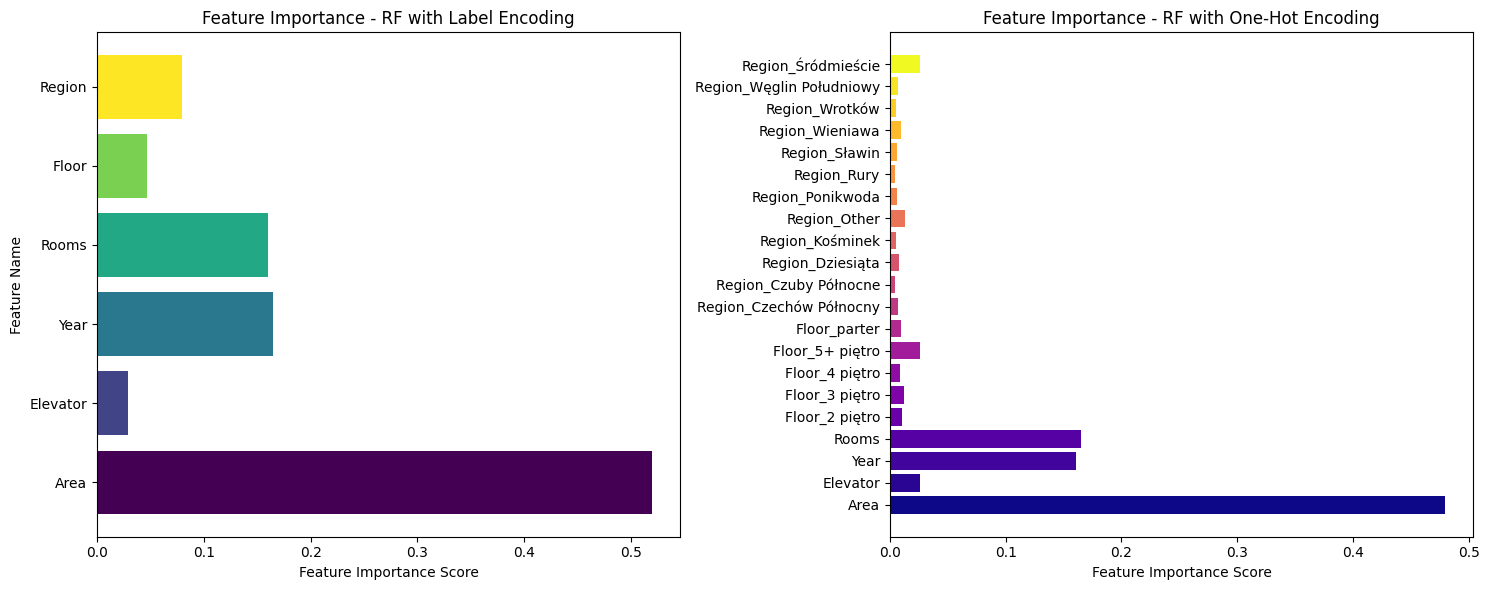

In [85]:
# Extract feature importances
models_list = ["RF-LE", "RF-OHE"]  # First two models
feature_importances = {}

for name in models_list:
    X_train, y_train = models[name][0], y_train_tree
    sample_weight = models[name][2] if models[name][2] is not None else None

    # Train model with best parameters
    best_model = RandomForestRegressor(**best_params[name], random_state=42)
    
    if sample_weight is not None:
        best_model.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        best_model.fit(X_train, y_train)
    
    feature_importances[name] = best_model.feature_importances_

# Get feature names
feature_names_le = models["RF-LE"][0].columns
feature_names_ohe = models["RF-OHE"][0].columns

# Plot Feature Importance - Side-by-Side (1x2 Grid)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Colors for bars
colors_le = plt.cm.viridis(np.linspace(0, 1, len(feature_names_le)))
colors_ohe = plt.cm.plasma(np.linspace(0, 1, len(feature_names_ohe)))

# First Plot: RF-LE (Label Encoding)
axes[0].barh(feature_names_le, feature_importances["RF-LE"], color=colors_le)
axes[0].set_title("Feature Importance - RF with Label Encoding")
axes[0].set_xlabel("Feature Importance Score")
axes[0].set_ylabel("Feature Name")

# Second Plot: RF-OHE (One-Hot Encoding)
axes[1].barh(feature_names_ohe, feature_importances["RF-OHE"], color=colors_ohe)
axes[1].set_title("Feature Importance - RF with One-Hot Encoding")
axes[1].set_xlabel("Feature Importance Score")

plt.tight_layout()
plt.show()

- In **Label Encoding (RF-LE)**, **Region** and **Floor** are treated as single features, making them **more important individually**.  
- In **One-Hot Encoding (RF-OHE)**, **categorical variables are split into multiple binary features**, reducing their **individual importance scores** but allowing for **better interactions** between them.  
- **Area and Rooms** remain the most influential features across both models, confirming their strong impact on house prices.  

Unfortunately, I was not able to achieve better results with GridSearchCV, comparing to the RF model in `4.7.2`. Additionally I tried also other approaches like simple weightening of the other samples and bigger number of parameters in `PARAM_GRID` for GridSearchCV, but it didn't help and rather overfit the model.

The best approach I found to improve the model performance, *but it is few cheating*, is to add more data, as I made train/test/validation split in `4.5` to teach and compare models in the same conditions, so adding to training set the validation set improve the model performance.

*I created the validation set to train and fine-tune neural network models by applying regularization and optimizing hyperparameters.*

To avoid data leakage, I apply Box-Cox transformation and Winsorization only after combining the train and validation sets. Otherwise, if applied separately, the transformations would have been learned on different distributions, leading to an unfair advantage and incorrect generalization.

Additionally, test set stays unchanged and all models will be evaluated on the same set.

In [86]:
# Train-Validation-Test Split 
X_train, X_temp, y_train, y_temp = train_test_split(X_tree, y_tree, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Combine Train & Validation Sets 
X_train_combined = pd.concat([X_train, X_val], axis=0)
y_train_combined = pd.concat([y_train, y_val], axis=0)

# Apply Transformations to Entire Training Data 
# Box-Cox transformation
X_train_combined['Area'], area_lambda = stats.boxcox(X_train_combined['Area'])
X_test['Area'] = stats.boxcox(X_test['Area'], lmbda=area_lambda)

# Winsorization 
X_train_combined['Year'], year_lower, year_upper = winsorize_series(X_train_combined['Year'])
X_test['Year'] = X_test['Year'].clip(lower=year_lower, upper=year_upper).astype(X_test['Year'].dtype)

# One-Hot Encoding for Categorical Features 
X_train_combined = pd.get_dummies(X_train_combined, columns=['Floor', 'Region'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Floor', 'Region'], drop_first=True)

# Ensure test set has the same features
missing_cols = set(X_train_combined.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train_combined.columns]

# Get one-hot encoded column names for 'Floor' and 'Region'
floor_columns = [col for col in X_train_combined.columns if col.startswith('Floor_')]
region_columns = [col for col in X_train_combined.columns if col.startswith('Region_')]

# Combine them into a list of categorical one-hot encoded columns
categorical_weight_columns = floor_columns + region_columns

weights_dict = {}

# Compute weights for one-hot encoded categorical features
for col in categorical_weight_columns:
    value_counts = X_train_combined[col].value_counts()
    weights_dict[col] = {val: len(X_train_combined) / count for val, count in value_counts.items()}

# Apply weights to one-hot encoded columns
for col in categorical_weight_columns:
    X_train_combined[f'{col}_Weight'] = X_train_combined[col].map(weights_dict[col])

# Compute sample weights by multiplying categorical feature weights
sample_weight = X_train_combined[[f'{col}_Weight' for col in categorical_weight_columns]].prod(axis=1)

# Drop weight columns before training
X_train_combined.drop(columns=[f'{col}_Weight' for col in categorical_weight_columns], inplace=True)

# Train the Random Forest Model with Grid Search 
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_combined, y_train_combined, sample_weight=sample_weight)

# Best model
best_rf_model = grid_search.best_estimator_

# Evaluate Model on the Test Set 
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate
rf_r2, rf_mae, rf_mse, rf_rmse, rf_mape, rf_rmsle = evaluate_model(y_test, y_pred_rf)

# Print results
print(f"Best Random Forest parameters: {grid_search.best_params_}")
print(f"R^2: {rf_r2:.4f}")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAPE: {rf_mape:.2f}")
print(f"RMSLE: {rf_rmsle:.4f}")

Best Random Forest parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R^2: 0.8163
MAE: 49230.79
RMSE: 73923.07
MAPE: 8.36
RMSLE: 0.1152


Random Forest with more data showed the best results, achieving the lowest MAE, RMSE, and MAPE, and the highest R². This confirms that **more data can improve model performance**.

So **in case if other models** will not perform better, I will use that model as final model for house price prediction.\
For model comparing I will use **previous Random Forest model** with one-hot encoding and weighted samples, to compare models in the same conditions.

Now, I will build boosting algorithms, which can handle complex relationships, reduce bias, and improve accuracy by combining multiple weak models into a strong one. 

### 5.6 Gradient Boosting Regressor

Now I will build boosting algorithms. Like for Random Forest, I tried four different approaches to build Gradient Boosting Regressor:
- **Label Encoding**
- **One-Hot Encoding**
- **Label Encoding with weighted samples**
- **One-Hot Encoding with weighted samples**

The second and fourth approaches performed the best. The second approach achieved a lower RMSE by approximately 2,000 PLN, while the fourth approach had a slightly lower MAE by around 900 PLN. Since RMSE is more critical for evaluating prediction errors, I will proceed with the second approach as the basis for building the remaining boosting algorithms.

So, prepare the data for the boosting algorithms.

In [87]:
# Make a copy of the dataset for boosting models
X_train_boost = X_train_tree_transformed.copy()
X_val_boost = X_val_tree_transformed.copy()
X_test_boost = X_test_tree_transformed.copy()

# One-Hot Encode categorical columns ('Floor' and 'Region')
X_train_boost = pd.get_dummies(X_train_boost, columns=['Floor', 'Region'], drop_first=True, dtype='int32')
X_val_boost = pd.get_dummies(X_val_boost, columns=['Floor', 'Region'], drop_first=True, dtype='int32')
X_test_boost = pd.get_dummies(X_test_boost, columns=['Floor', 'Region'], drop_first=True, dtype='int32')

Build Gradient Boosting Regressor with One-Hot Encoding.

In [88]:
# Define parameter grid for Grid Search CV
param_grid_gbr = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Gradient Boosting model
gbr = GradientBoostingRegressor(random_state=42)

# Perform Grid Search CV
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, cv=5, scoring='r2', n_jobs=-1)
grid_search_gbr.fit(X_train_boost, y_train_tree)

# Get the best model
best_gbr_model = grid_search_gbr.best_estimator_

# Predict on the test set
y_pred_gbr = best_gbr_model.predict(X_test_boost)

# Evaluate the best model
gbr_r2, gbr_mae, gbr_mse, gbr_rmse, gbr_mape, gbr_rmsle = evaluate_model(y_test_tree, y_pred_gbr)

# Print best hyperparameters
print(f"Best Gradient Boosting parameters: {grid_search_gbr.best_params_}")

# Print results
print(f"R²: {gbr_r2:.4f}")
print(f"MAE: {gbr_mae:.2f}")
print(f"RMSE: {gbr_rmse:.2f}")
print(f"MAPE: {gbr_mape:.2f}")
print(f"RMSLE: {gbr_rmsle:.4f}")

Best Gradient Boosting parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
R²: 0.7898
MAE: 55474.82
RMSE: 79090.55
MAPE: 9.67
RMSLE: 0.1275


The Gradient Boosting Regresso showed slightly worse results compared to the Random Forest model. 

### 5.7 XGBoost Regressor

In [89]:
# Define parameter grid for Grid Search CV
param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform Grid Search CV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train_boost, y_train_tree)

# Get the best model
best_xgb_model = grid_search_xgb.best_estimator_

# Predict on the test set
y_pred_xgb = best_xgb_model.predict(X_test_boost)

# Evaluate the best model
xgb_r2, xgb_mae, xgb_mse, xgb_rmse, xgb_mape, xgb_rmsle = evaluate_model(y_test_tree, y_pred_xgb)

# Print best hyperparameters
print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")

# Print results
print(f"R²: {xgb_r2:.4f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAPE: {xgb_mape:.2f}")
print(f"RMSLE: {xgb_rmsle:.4f}")

Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}
R²: 0.7856
MAE: 54198.80
RMSE: 79873.50
MAPE: 9.35
RMSLE: 0.1256


XGBoost showed similar results to Gradient Boosting, with slightly higher RMSE and lower MAE.

### 5.8 LightGBM Regressor

LightGBM more often used for large datasets, but instead of that I will try it on this dataset to check if it will perform better than previous models.

In [116]:
# Define parameter grid for Grid Search CV
param_grid_lgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42, force_col_wise=True, verbose = -1)

# Perform Grid Search CV
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=5, scoring='r2', n_jobs=-1)
grid_search_lgb.fit(X_train_boost, y_train_tree)

# Get the best model
best_lgb_model = grid_search_lgb.best_estimator_

# Predict on the test set
y_pred_lgb = best_lgb_model.predict(X_test_boost)

# Evaluate the best model
lgb_r2, lgb_mae, lgb_mse, lgb_rmse, lgb_mape, lgb_rmsle = evaluate_model(y_test_tree, y_pred_lgb)

# Print best hyperparameters
print(f"Best LightGBM parameters: {grid_search_lgb.best_params_}")

# Print results
print(f"R²: {lgb_r2:.4f}")
print(f"MAE: {lgb_mae:.2f}")
print(f"RMSE: {lgb_rmse:.2f}")
print(f"MAPE: {lgb_mape:.2f}")
print(f"RMSLE: {lgb_rmsle:.4f}")

Best LightGBM parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.8}
R²: 0.7792
MAE: 55832.17
RMSE: 81047.91
MAPE: 9.60
RMSLE: 0.1268


LightGBM showed few worse results than XGBoost and Gradient Boosting.

### 5.9 CatBoost Regressor

**CatBoost** is different from **LightGBM** and **XGBoost** because it natively supports categorical features, so there is no need to one-hot encode them. 

This algorithm works good with categorical features, so let's try it on the our dataset.

In [91]:
# Make a copy of the dataset for CatBoost
X_train_cat = X_train_tree_transformed.copy()
X_val_cat = X_val_tree_transformed.copy()
X_test_cat = X_test_tree_transformed.copy()

# Identify categorical columns
cat_features = ['Floor', 'Region']

# Label Encode categorical columns
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train_cat[col] = le.fit_transform(X_train_cat[col])
    X_val_cat[col] = le.transform(X_val_cat[col])
    X_test_cat[col] = le.transform(X_test_cat[col])
    label_encoders[col] = le  # Store encoders for consistency

# Define parameter grid for Grid Search CV
param_grid_cat = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

# Initialize CatBoost model
cat_model = CatBoostRegressor(loss_function='RMSE', random_seed=42, silent=True)

# Perform Grid Search CV
grid_search_cat = GridSearchCV(cat_model, param_grid_cat, cv=5, scoring='r2', n_jobs=-1)
grid_search_cat.fit(X_train_cat, y_train_tree)

# Get the best model
best_cat_model = grid_search_cat.best_estimator_

# Predict on the test set
y_pred_cat = best_cat_model.predict(X_test_cat)

# Evaluate the best model
cat_r2, cat_mae, cat_mse, cat_rmse, cat_mape, cat_rmsle = evaluate_model(y_test_tree, y_pred_cat)

# Print best hyperparameters
print(f"Best CatBoost parameters: {grid_search_cat.best_params_}")

# Print results
print(f"R²: {cat_r2:.4f}")
print(f"MAE: {cat_mae:.2f}")
print(f"RMSE: {cat_rmse:.2f}")
print(f"MAPE: {cat_mape:.2f}")
print(f"RMSLE: {cat_rmsle:.4f}")

Best CatBoost parameters: {'border_count': 128, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
R²: 0.7974
MAE: 52438.95
RMSE: 77647.95
MAPE: 9.05
RMSLE: 0.1217


**CatBoost** performed the best results among all boosting algorithms, with the lowest RMSE and MAE. Comparing to Random Forest model, it achieved few lower RMSE around 200 PLN and approximately the same MAE.

Since CatBoost has demonstrated strong performance, I aim to train a CatBoost model using the combined training and validation sets - similar to the approach used for Random Forest.

In [92]:
# 1. Train-Validation-Test Split 
X_train, X_temp, y_train, y_temp = train_test_split(X_tree, y_tree, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 2. Combine Training and Validation Sets 
X_train_combined = pd.concat([X_train, X_val], axis=0)
y_train_combined = pd.concat([y_train, y_val], axis=0)

# Apply Transformations to the Entire Training Data 
# Box-Cox Transformation (Calculate Lambda on Combined Train Set)
X_train_combined['Area'], area_lambda = stats.boxcox(X_train_combined['Area'])
X_test['Area'] = stats.boxcox(X_test['Area'], lmbda=area_lambda)

# Winsorization (Calculate Limits on Combined Train Set)
X_train_combined['Year'], year_lower, year_upper = winsorize_series(X_train_combined['Year'])
X_test['Year'] = X_test['Year'].clip(lower=year_lower, upper=year_upper).astype(X_test['Year'].dtype)

# 4. Identify Categorical Columns 
cat_features = ['Floor', 'Region']

# 5. Label Encode Categorical Columns AFTER Combining Train & Validation 
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train_combined[col] = le.fit_transform(X_train_combined[col])  
    X_test[col] = le.transform(X_test[col])  
    label_encoders[col] = le  

# 6. Define Parameter Grid for CatBoost 
param_grid_cat = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

# Initialize and Train CatBoost Model 
cat_model = CatBoostRegressor(loss_function='RMSE', random_seed=42, silent=True)

# Perform Grid Search CV
grid_search_cat = GridSearchCV(cat_model, param_grid_cat, cv=5, scoring='r2', n_jobs=-1)
grid_search_cat.fit(X_train_combined, y_train_combined)

# Get the best model
best_cat_model = grid_search_cat.best_estimator_

# 8. Predict on the Test Set 
y_pred_cat = best_cat_model.predict(X_test)

# 9. Evaluate the Model 
cat_combine_r2, cat_combine_mae, cat_combine_mse, cat_combine_rmse, cat_combine_mape, cat_combine_rmsle = evaluate_model(y_test, y_pred_cat)

# Print Best Hyperparameters
print(f"Best CatBoost parameters: {grid_search_cat.best_params_}")

print(f"R²: {cat_combine_r2:.4f}")
print(f"MAE: {cat_combine_mae:.2f}")
print(f"RMSE: {cat_combine_rmse:.2f}")
print(f"MAPE: {cat_combine_mape:.2f}")
print(f"RMSLE: {cat_combine_rmsle:.4f}")

Best CatBoost parameters: {'border_count': 128, 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
R²: 0.8083
MAE: 51948.94
RMSE: 75523.09
MAPE: 8.89
RMSLE: 0.1182


While CatBoost achieved strong results, the Random Forest model performed better using the same approach and took less time for training. Therefore, I will select Random Forest as the final model for house price prediction unless neural networks yield superior performance.

Additionally I will visualize their metrics to compare them.

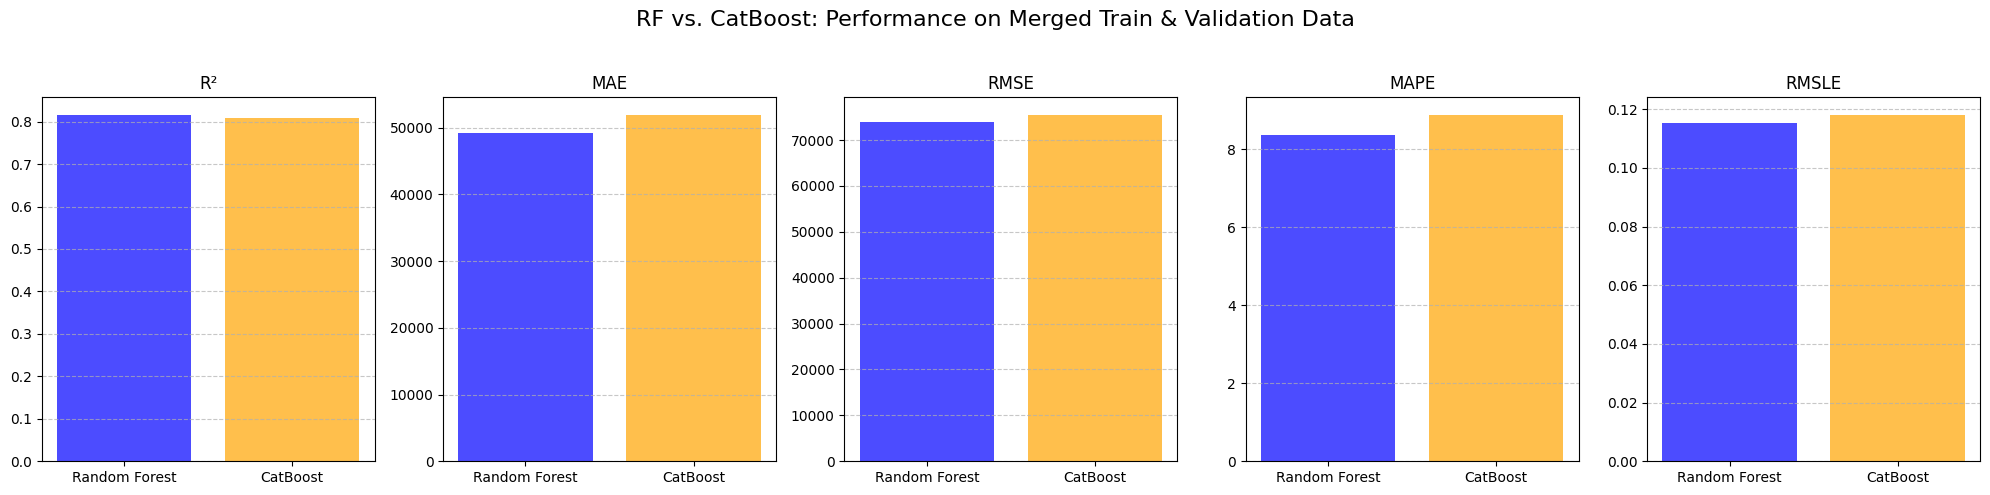

In [93]:
# Metrics data (excluding MSE)
metrics = ['R²', 'MAE', 'RMSE', 'MAPE', 'RMSLE']
rf_metrics = [rf_r2, rf_mae, rf_rmse, rf_mape, rf_rmsle]
cat_metrics = [cat_combine_r2, cat_combine_mae, cat_combine_rmse, cat_combine_mape, cat_combine_rmsle]

# Create subplots (1x5 grid)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Plot each metric separately
for i, metric in enumerate(metrics):
    axes[i].bar(['Random Forest', 'CatBoost'], [rf_metrics[i], cat_metrics[i]], color=['blue', 'orange'], alpha=0.7)
    axes[i].set_title(metric)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Add overall title
fig.suptitle('RF vs. CatBoost: Performance on Merged Train & Validation Data', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Across all metrics Random Forest model performed the best.

Now, let's move to the comparison of the whole models on training, validation and test sets.

### 5.10 Model Comparison

Finally let's compare all models to choose which showed the best results.

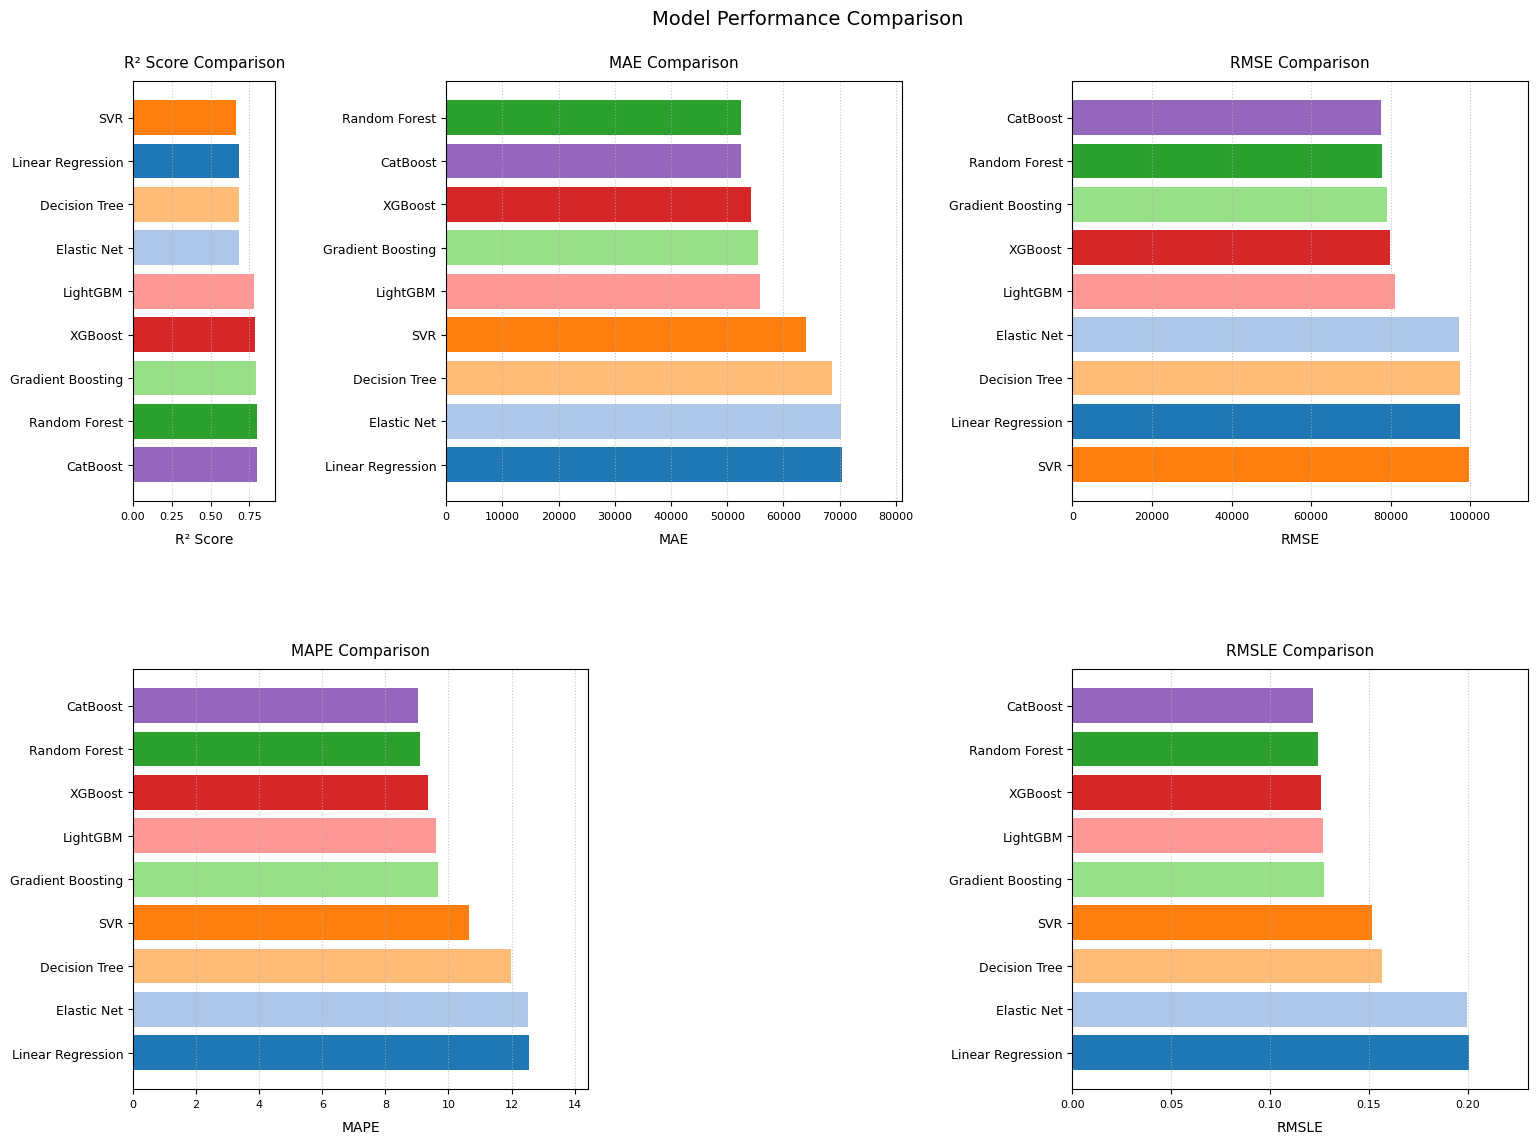

In [94]:
# Define metric values for each model
r2_scores = {
    "Linear Regression": lr_r2,
    "Elastic Net": elastic_r2,
    "SVR": svr_r2,
    "Decision Tree": dt_r2,
    "Random Forest": results_df.loc['RF-OHE-Weighted', 'R²'],
    "Gradient Boosting": gbr_r2,
    "XGBoost": xgb_r2,
    "LightGBM": lgb_r2,
    "CatBoost": cat_r2
}

mae_scores = {
    "Linear Regression": lr_mae,
    "Elastic Net": elastic_mae,
    "SVR": svr_mae,
    "Decision Tree": dt_mae,
    "Random Forest": results_df.loc['RF-OHE-Weighted', 'MAE'],
    "Gradient Boosting": gbr_mae,
    "XGBoost": xgb_mae,
    "LightGBM": lgb_mae,
    "CatBoost": cat_mae
}

rmse_scores = {
    "Linear Regression": lr_rmse,
    "Elastic Net": elastic_rmse,
    "SVR": svr_rmse,
    "Decision Tree": dt_rmse,
    "Random Forest": results_df.loc['RF-OHE-Weighted', 'RMSE'],
    "Gradient Boosting": gbr_rmse,
    "XGBoost": xgb_rmse,
    "LightGBM": lgb_rmse,
    "CatBoost": cat_rmse
}

mape_scores = {
    "Linear Regression": lr_mape,
    "Elastic Net": elastic_mape,
    "SVR": svr_mape,
    "Decision Tree": dt_mape,
    "Random Forest": results_df.loc['RF-OHE-Weighted', 'MAPE'],
    "Gradient Boosting": gbr_mape,
    "XGBoost": xgb_mape,
    "LightGBM": lgb_mape,
    "CatBoost": cat_mape
}

rmsle_scores = {
    "Linear Regression": lr_rmsle,
    "Elastic Net": elastic_rmsle,
    "SVR": svr_rmsle,
    "Decision Tree": dt_rmsle,
    "Random Forest": results_df.loc['RF-OHE-Weighted', 'RMSLE'],
    "Gradient Boosting": gbr_rmsle,
    "XGBoost": xgb_rmsle,
    "LightGBM": lgb_rmsle,
    "CatBoost": cat_rmsle
}

# Plot all metrics in one function call
plot_model_performance(r2_scores, mae_scores, rmse_scores, mape_scores, rmsle_scores)

Among all tested models, **CatBoost** and **Random Forest** performed the best results, wherein **CatBoost** showed better in most metrics, instead of MAE, where **Random Forest** achieved slightly better results around 20 PLN, what is not significant. Other boosting algorithms like **XGBoost** and **Gradient Boosting** showed slightly worse results in most cases by distilling **LightGBM**. Linear models like **Linear Regression**, **Elastic Net**, **SVR** and **Decision Tree** performed the worst, struggling to capture the complex relationships in the data.

### 5.11 Stacking Model

As I will build two stacking models, I wrote a function `prepare_data_for_stacking` to prepare the data for the stacking models.\
First stacking model will be build only on the train set, while the second one will be build on the train and validation sets.\
First Stacking model is the combination of the next models: **Random Forest**, **CatBoost**, **XGBoost**, as they showed the best results.
Second Stacking model is the combination of the next models: **Random Forest** and **CatBoost** on the train and validation sets.

As CatBoost, Random Forest and XGBoost performed well, I will combine them into a **Stacking Regressor** to leverage their strengths and improve overall performance. For that I will use only training set, without validation set.

In [95]:
# Prepare datasets for Stacking Model (Train Set Only)
data_stacking = prepare_data_for_stacking(X_tree, y_tree, use_combined_train_val=False)

# Define Base Models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=20, max_features='sqrt', min_samples_split=2, min_samples_leaf=1, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, l2_leaf_reg=3, border_count=128, loss_function='RMSE', random_seed=42, silent=True)),
    ('xgb', XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=7, min_child_weight=5, subsample=0.8, colsample_bytree=0.8, random_state=42))
]

# Define and Train Stacking Model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression(), n_jobs=-1)
stacking_model.fit(data_stacking['X_train_rf'], data_stacking['y_train'])

# Predict and Evaluate
y_pred_stack = stacking_model.predict(data_stacking['X_test_rf'])
stack_r2, stack_mae, stack_mse, stack_rmse, stack_mape, stack_rmsle = evaluate_model(data_stacking['y_test'], y_pred_stack)

# Print Results
print(f"Stacking Model Performance:")
print(f"R²: {stack_r2:.4f}, \nMAE: {stack_mae:.2f}, \nRMSE: {stack_rmse:.2f}, \nMAPE: {stack_mape:.2f}, \nRMSLE: {stack_rmsle:.4f}")

Stacking Model Performance:
R²: 0.8250, 
MAE: 49128.42, 
RMSE: 72154.98, 
MAPE: 8.35, 
RMSLE: 0.1130


The **Stacking Model** performed better than **CatBoost**, **Random Forest** and **XGBoost** alone, achieving the lowest RMSE and MAE, and the highest R². This confirms that **combining multiple models can improve overall performance**. 

In [96]:
# Prepare datasets for Stacking Model (Train + Validation)
data_combined = prepare_data_for_stacking(X_tree, y_tree, use_combined_train_val=True, models=['rf', 'cat'])

# Define Base Models (RF + CatBoost)
base_models_combined = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_split=2, min_samples_leaf=1, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, l2_leaf_reg=1, border_count=128, loss_function='RMSE', random_seed=42, silent=True))
]

# Train Stacking Model
stacking_model_combined = StackingRegressor(estimators=base_models_combined, final_estimator=LinearRegression(), n_jobs=-1)
stacking_model_combined.fit(data_combined['X_train_rf'], data_combined['y_train'])

# Predict and Evaluate
y_pred_stack_combined = stacking_model_combined.predict(data_combined['X_test_rf'])
stack_combined_r2, stack_combined_mae, stack_combined_mse, stack_combined_rmse, stack_combined_mape, stack_combined_rmsle = evaluate_model(data_combined['y_test'], y_pred_stack_combined)

print(f"Stacking Model Performance (RF + CatBoost): \nR²: {stack_combined_r2:.4f}, \nMAE: {stack_combined_mae:.2f}, \nRMSE: {stack_combined_rmse:.2f}, \nMAPE: {stack_combined_mape:.2f}, \nRMSLE: {stack_combined_rmsle:.4f}")

Stacking Model Performance (RF + CatBoost): 
R²: 0.8366, 
MAE: 47175.79, 
RMSE: 69718.76, 
MAPE: 8.01, 
RMSLE: 0.1088


The combination of **Random Forest** and **CatBoost** on the train and validation sets achieved better results than this two models alone, so stacking models can be a good approach to improve the model performance. Of course it is very important to remember about the possible overfitting and be with it careful.

Now let's try to build neural networks models.

## 6. Build Deep Learning Models

For building neural networks I will use standardized numerical features and one-hot encoded categorical features, because neural networks work better with them.

To keep the code more organized and modular, I moved the model architecture, training process, and data handling functions to the `help_functions.py` script.

In [79]:
from help_functions import create_dataloaders, create_test_loader, HousePriceFNN, RMSLELoss, train_model, plot_training_history

### 6.1 Feedforward Neural Network

So, let's start from FNN model.

The model has six hidden layers (512-256-128-64-32-16 neurons) with *ReLU* activations and *dropout* to prevent overfitting, uses *RMSLE loss* to handle large relative errors more effectively than *MSE*, and applies early stopping based on validation loss to avoid overtraining.

**Why RMSLE loss function?**

The **Root Mean Squared Logarithmic Error (RMSLE)** is defined as:  

$RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(y_{\text{pred}} + 1) - \log(y_{\text{true}} + 1) \right)^2}$

- **Penalizes underestimation more than overestimation**, which is crucial in house price prediction.  
- **More stable on skewed price distributions**.

Epoch [25/300] | Train Loss: 0.1588 | Val Loss: 0.1464
Epoch [50/300] | Train Loss: 0.1561 | Val Loss: 0.1443
Epoch [75/300] | Train Loss: 0.1542 | Val Loss: 0.1443
Epoch [100/300] | Train Loss: 0.1510 | Val Loss: 0.1448
Early stopping at epoch 110 | Best Val Loss: 0.1428


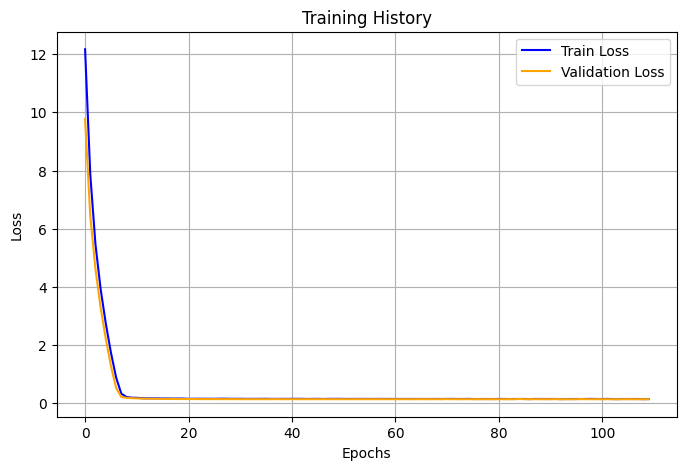

R²: 0.7544
MAE: 58699.89
RMSE: 85488.80
MAPE: 31.89
RMSLE: 0.1304


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

batch_size = 16
train_loader, val_loader, input_size = create_dataloaders(
    X_train_linear_transformed, y_train_linear, X_val_linear_transformed, y_val_linear, batch_size
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HousePriceFNN(input_size).to(device)
criterion = RMSLELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=300, patience=15, device=device)
plot_training_history(history)

test_loader = create_test_loader(X_test_linear_transformed, y_test_linear, batch_size=16)

# Evaluate on Test Set
model.eval()
y_test_pred, y_test_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = np.maximum(model(X_batch).cpu().numpy().astype(np.float32).squeeze(), 0)
        y_test_pred.extend(preds)
        y_test_true.extend(y_batch.cpu().numpy())

y_test_pred_fnn, y_test_true_fnn = np.array(y_test_pred), np.array(y_test_true)

# Evaluate Performance
fnn_r2, fnn_mae, fnn_mse, fnn_rmse, fnn_mape, fnn_rmsle = evaluate_model(y_test_true_fnn, y_test_pred_fnn)
print(f"R²: {fnn_r2:.4f}\nMAE: {fnn_mae:.2f}\nRMSE: {fnn_rmse:.2f}\nMAPE: {fnn_mape:.2f}\nRMSLE: {fnn_rmsle:.4f}")

Model showed poor results compared to ML models, with early stopping halting training after 110 epochs.

### 6.2 Convolutional Neural Network

**Model Description:**  
The model has three convolutional layers (16-32-64 filters) with *ReLU* activations, batch normalization, and *dropout* to prevent overfitting, followed by three fully connected layers (128-64-32 neurons) and a final output layer for regression, uses *MAPE loss* to minimize percentage-based prediction errors, and applies early stopping based on validation loss to prevent overtraining.  

**Why MAPE loss function?**  
The **Mean Absolute Percentage Error (MAPE)** is defined as:  

$\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \frac{|y_{\text{true}} - y_{\text{pred}}|}{y_{\text{true}} + \epsilon}$

- MAPE minimizes **relative percentage errors** rather than absolute values.  
- It works well when target values have a **wide range** and different scales.  

Epoch [25/100] | Train Loss: 14.4471 | Val Loss: 12.4533
Epoch [50/100] | Train Loss: 12.2462 | Val Loss: 10.5599
Epoch [75/100] | Train Loss: 11.5605 | Val Loss: 10.5053
Early stopping at epoch 96 | Best Val Loss: 10.1028


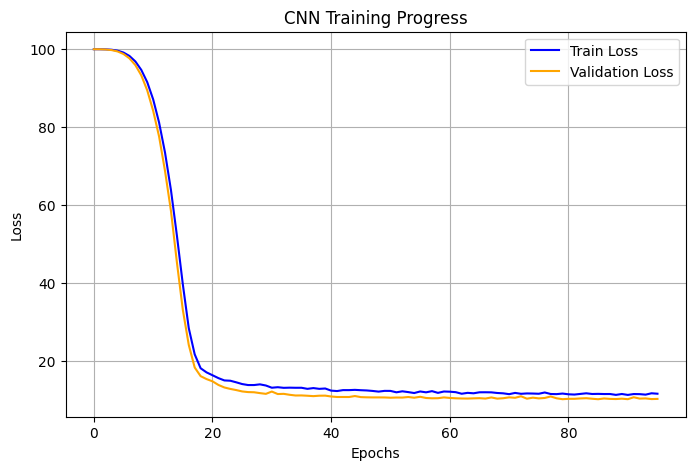

R²: 0.7212
MAE: 59304.77
RMSE: 91080.16
MAPE: 29.56
RMSLE: 0.1358


In [82]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

# Create DataLoader for CNN 
batch_size = 16
train_loader, val_loader, input_size = create_dataloaders(
    X_train_linear_transformed, y_train_linear, X_val_linear_transformed, y_val_linear, batch_size, cnn_input=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HousePriceCNN(input_size).to(device)
criterion = MAPELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, device=device)
plot_training_history(history, title="CNN Training Progress")

test_loader = create_test_loader(X_test_linear_transformed, y_test_linear, batch_size=16,cnn_input=True)

# Evaluate Model 
model.eval()
y_pred = []
y_true = []

# Evaluate on Test Set
model.eval()
y_test_pred, y_test_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = np.maximum(model(X_batch).cpu().numpy().astype(np.float32).squeeze(), 0)
        y_test_pred.extend(preds)
        y_test_true.extend(y_batch.cpu().numpy())

y_test_pred_cnn, y_test_true_cnn = np.array(y_test_pred), np.array(y_test_true)

# Evaluate Performance
cnn_r2, cnn_mae, cnn_mse, cnn_rmse, cnn_mape, cnn_rmsle = evaluate_model(y_test_true_cnn, y_test_pred_cnn)
print(f"R²: {cnn_r2:.4f}\nMAE: {cnn_mae:.2f}\nRMSE: {cnn_rmse:.2f}\nMAPE: {cnn_mape:.2f}\nRMSLE: {cnn_rmsle:.4f}")

The CNN showed lower *R²* and higher *MAE*, *RMSE* compared to the FNN, with early stopping after 96 epochs; both neural networks performed worse than previous ML models.

We successfully built two neural networks models, let's explore the possibility of building an RNN, but first, let's check for autocorrelation.

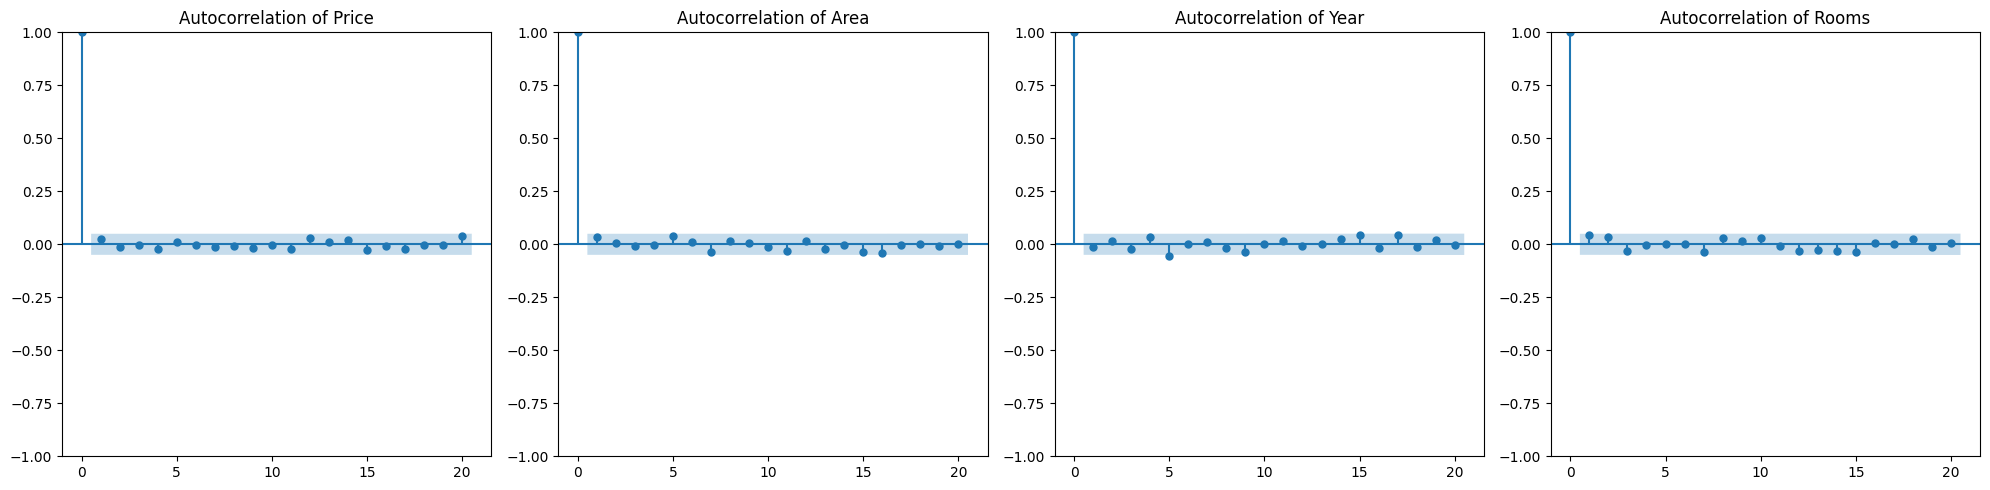

In [100]:
numerical_columns = ['Area', 'Year', 'Rooms']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
sm.graphics.tsa.plot_acf(y_train_linear.dropna(), lags=20, ax=axes[0], title="Autocorrelation of Price")
for i, col in enumerate(numerical_columns):
    sm.graphics.tsa.plot_acf(X_train_linear_transformed.dropna()[col], lags=20, ax=axes[i + 1], title=f"Autocorrelation of {col}")
plt.tight_layout()
plt.show()

There is no significant autocorrelation; autocorrelation drops to zero after 1 lag. This confirms that **RNNs** are not a good fit, as the dataset does not follow a time-series structure. 

## 7. Model Comparison and Interpretation

### 7.1 Compare All Model Metrics

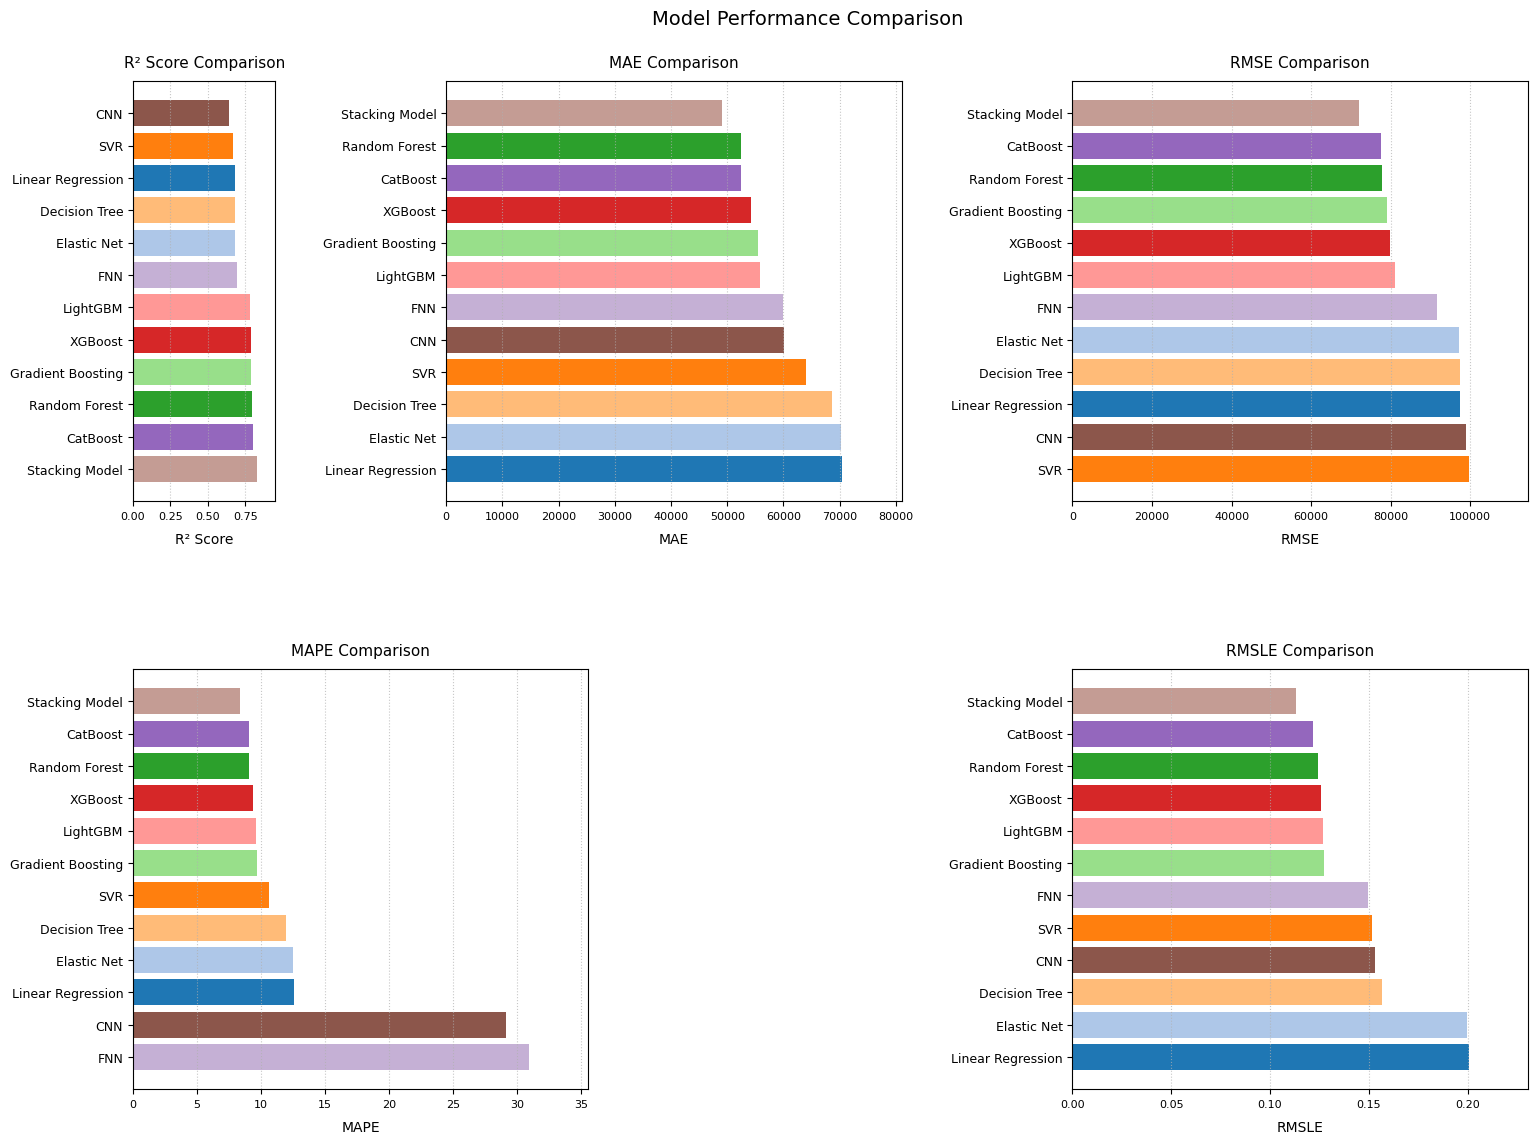

In [115]:
# Add Neural Network Models to Metrics Dictionary
r2_scores.update({
    "FNN": fnn_r2,
    "CNN": cnn_r2,
    "Stacking Model": stack_r2
})

mae_scores.update({
    "FNN": fnn_mae,
    "CNN": cnn_mae,
    "Stacking Model": stack_mae
})

rmse_scores.update({
    "FNN": fnn_rmse,
    "CNN": cnn_rmse,
    "Stacking Model": stack_rmse
})

mape_scores.update({
    "FNN": fnn_mape,
    "CNN": cnn_mape,
    "Stacking Model": stack_mape
})

rmsle_scores.update({
    "FNN": fnn_rmsle,
    "CNN": cnn_rmsle,
    "Stacking Model": stack_rmsle
})

plot_model_performance(r2_scores, mae_scores, rmse_scores, mape_scores, rmsle_scores)

**Analysis and Conclusion:**

1. **R² Score:**  
   - The *Stacking Model* achieved the highest R² score (~0.83), followed by *CatBoost* and *Random Forest* (~0.80).  
   - Neural networks (FNN and CNN) underperformed on R², with CNN showing the lowest score (~0.64), indicating weaker ability to explain variance in the data.  

2. **MAE:**  
   - The *Stacking Model* had the lowest MAE (~49K), indicating the most accurate absolute predictions.  
   - Neural networks (FNN and CNN) showed higher MAE (~60K), reflecting poorer accuracy in absolute terms compared to tree-based models.  

3. **RMSE:**  
   - Tree-based models (Random Forest, CatBoost) and the Stacking Model showed the lowest RMSE (~72K–78K), indicating more stable predictions.  
   - Neural networks showed higher RMSE, especially CNN (~99K), highlighting higher sensitivity to large errors.  

4. **MAPE:**  
   - Neural networks (FNN and CNN) had **much higher MAPE** (~28%–31%), indicating poor performance on percentage-based errors, likely due to sensitivity.  
   - The Stacking Model had the lowest MAPE (~8%), showing more consistent accuracy across different price ranges.  

5. **RMSLE:**  
   - The Stacking Model had the lowest RMSLE (~0.11), indicating well-balanced performance on both large and small values.  
   - Neural networks had moderately high RMSLE (~0.15), reflecting difficulty in capturing both high and low value predictions accurately.  

**Conclusion:**  
Tree-based models (especially CatBoost, Random Forest, and the Stacking Model) demonstrated more consistent and balanced performance across all metrics. Neural networks showed competitive performance on R² and RMSLE but struggled with high MAPE and MAE, highlighting sensitivity to scale and outliers. The Stacking Model emerged as the overall best performer in terms of predictive accuracy and error stability.

### 7.2 Feature Importance

Since SHAP cannot be used directly for the Stacking Model, I built a function to analyze the feature importance and predictions of the base models (Random Forest or CatBoost), allowing me to select the model type through function parameters to understand key drivers of house prices and how the model makes decisions.

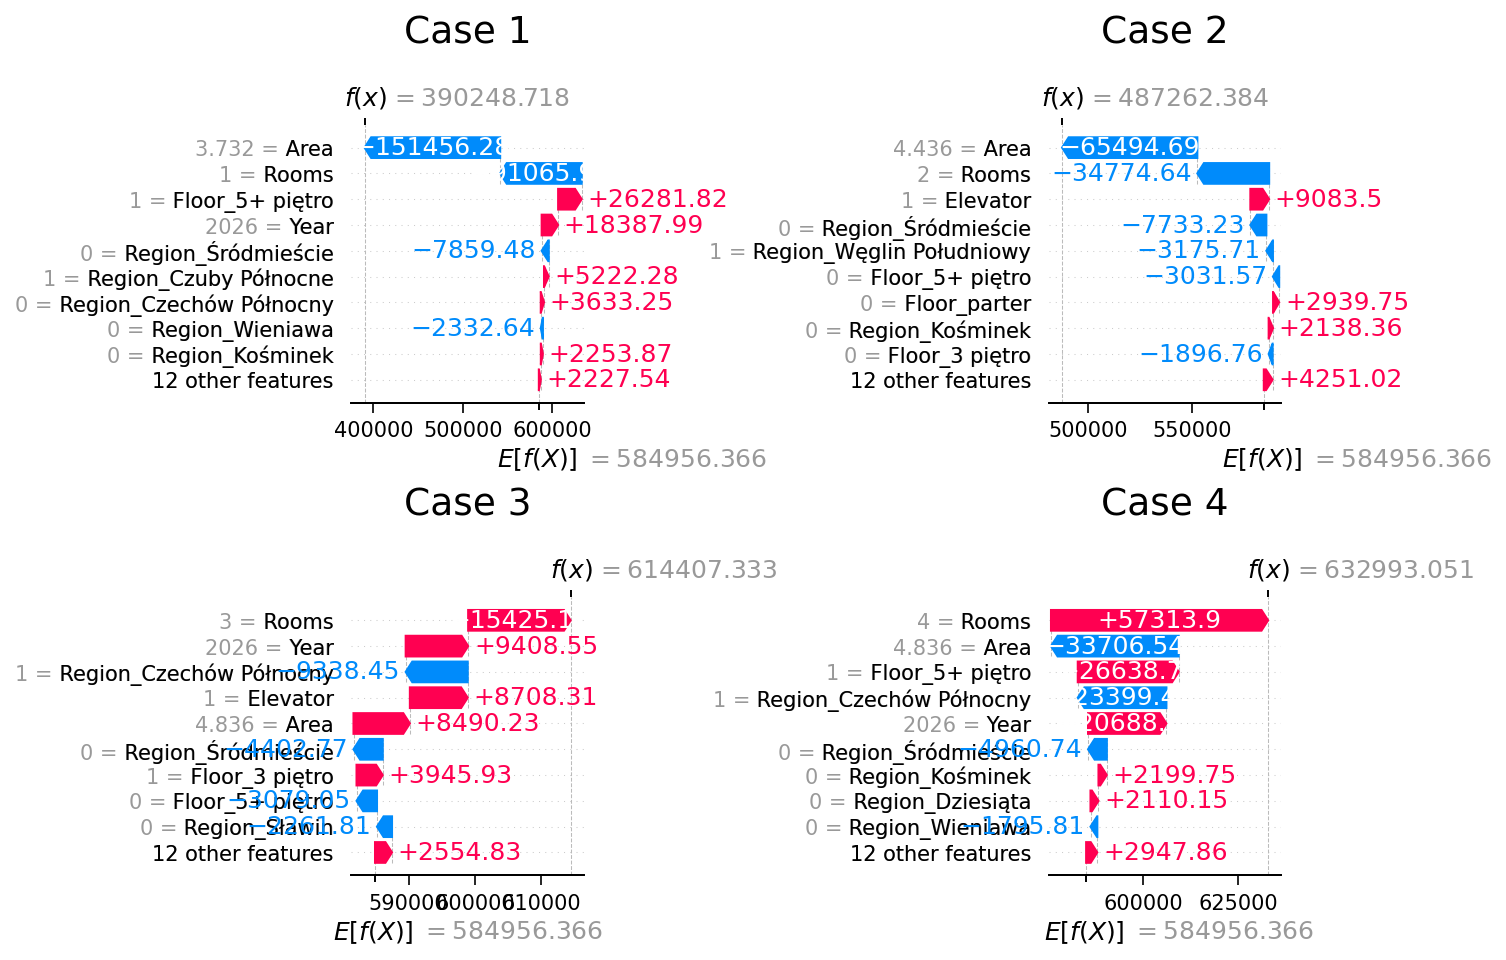

In [102]:
plot_shap_explanations(stacking_model_combined, data_combined['X_test_rf'], model_type='rf', seed=46)

Area and the number of rooms are the dominant predictors across all cases. The model effectively captures the effect of location, floor level, and building characteristics, indicating that the stacking model is learning meaningful patterns from the data.

### 7.3 Worst model predictions

To understand why the model struggles with certain predictions, I will:
- Identify the 10 worst predictions (largest absolute errors).
- Compare actual vs predicted prices.
- Analyze possible reasons for these misclassifications.

In [103]:
# Predict values
y_pred_stack_combined = stacking_model_combined.predict(data_combined['X_test_rf'])

# Create DataFrame with actual, predicted values, and absolute error
results_df = pd.DataFrame({
    'Actual': data_combined['y_test'].values,
    'Predicted': y_pred_stack_combined,
    'Absolute Error': abs(data_combined['y_test'].values - y_pred_stack_combined)
})

# Add the corresponding feature values from X_test
features_df = pd.DataFrame(data_combined['X_test_rf'], columns=data_combined['X_test_rf'].columns)

# Merge predictions and feature data
results_df = pd.concat([results_df, features_df.reset_index(drop=True)], axis=1)

# Back-encode One-Hot Encoded Columns 
floor_columns = [col for col in results_df.columns if col.startswith('Floor_')]
results_df['Floor'] = results_df[floor_columns].idxmax(axis=1).str.replace('Floor_', '')
region_columns = [col for col in results_df.columns if col.startswith('Region_')]
results_df['Region'] = results_df[region_columns].idxmax(axis=1).str.replace('Region_', '')
results_df.drop(columns=floor_columns + region_columns, inplace=True)

# Inverse Box-Cox Transformation for 'Area' 
if area_lambda == 0:
    results_df['Area'] = np.exp(results_df['Area']) 
else:
    results_df['Area'] = inv_boxcox(results_df['Area'], area_lambda)


conversion_data = pd.read_csv('data/conversion_data.csv')
matched_names = []
for index, row in results_df.iterrows():
    match = conversion_data[
        (conversion_data['Price'].round(2) == round(row['Actual'], 2)) &
        (conversion_data['Rooms'] == row['Rooms']) &
        (conversion_data['Area'].round(2) == round(row['Area'], 2))
    ]
    if not match.empty:
        matched_names.append(match.iloc[0]['Name'])
    else:
        matched_names.append('Not Found')
results_df['Name'] = matched_names

# Sort by absolute error in descending order 
worst_predictions = results_df.sort_values(by='Absolute Error', ascending=False).head(10)
worst_predictions['Actual'] = worst_predictions['Actual'].apply(lambda x: f"{x:,.2f}")
worst_predictions['Predicted'] = worst_predictions['Predicted'].apply(lambda x: f"{x:,.2f}")
worst_predictions['Absolute Error'] = worst_predictions['Absolute Error'].apply(lambda x: f"{x:,.2f}")
worst_predictions['Area'] = worst_predictions['Area'].apply(lambda x: f"{x:,.2f}")
worst_predictions = worst_predictions[['Actual', 'Predicted', 'Absolute Error', 'Area', 'Rooms', 'Year', 'Floor', 'Region', 'Name']]

# Output the worst 10 predictions 
print("\nWorst 10 Predictions by Absolute Error:")
print(worst_predictions.to_string(index=False))


Worst 10 Predictions by Absolute Error:
      Actual    Predicted Absolute Error   Area  Rooms  Year     Floor         Region                                              Name
  927,384.00   562,000.06     365,383.94  45.46      2  <NA>  4 piętro    Śródmieście                      Mieszkanie, 45,46 m², Lublin
1,299,000.00   963,003.47     335,996.53  81.00      3  2013 5+ piętro           Rury  Metropolitan Park 16 piętro widok 81m2, 3 pokoje
  954,720.00   634,021.76     320,698.24  46.80      3  2024  4 piętro    Śródmieście  Niecała Prestige Residence | nowe mieszkanie M24
1,049,400.00   753,054.94     296,345.06  63.60      3  2024  3 piętro Czuby Północne ! M3 + taras 125 m2 od dewelopera, Lublin, Orkana
  950,000.00   686,997.14     263,002.86  56.74      2  2024  4 piętro    Śródmieście     Mieszkanie w Centrum 0% PCC ul. Wieniawska 11
1,050,000.00   802,673.50     247,326.50  77.00      3  2023  2 piętro         Sławin             Mieszkanie 3Pokojowe 77M2 Na Sławinie
  860,0

The model mostly predicts lower prices for different types of houses with varying numbers of rooms, and it is difficult to identify strong reasons for this pattern based on the advertisement names.

To improve predictions, it would be beneficial to include an additional feature that assesses **property condition** based on factors such as interior quality, renovation status, and materials used. Alternatively, these features could be combined into a single metric that reflects the overall quality of the repair, which may significantly influence house prices.

## 8. Final Model & Predictions

### 8.1 Save Random Forest Model

Save Stacking model teached on train and validation sets from 5.11 section and all necessary components to make predictions in the future.

In [104]:
# Save components
joblib.dump(stacking_model_combined, 'model_components/stacking_model.pkl')
joblib.dump((data_combined['X_train_rf'], data_combined['y_train'], 
             data_combined['X_test_rf'], data_combined['y_test']), 'model_components/data_split.pkl')
if 'sample_weight_rf' in data_combined:
    joblib.dump(data_combined['sample_weight_rf'], 'model_components/sample_weights.pkl')
joblib.dump(area_lambda, 'model_components/boxcox_lambda.pkl')
joblib.dump((year_lower, year_upper), 'model_components/winsorization_limits.pkl')

['model_components/winsorization_limits.pkl']

### 8.2 Predictions on New Data

Load function to predict house prices on new data.

In [105]:
from help_functions import predict_house_price

The `predict_house_price` function predicts house prices based on input features (`Area`, `Elevator`, `Year`, `Rooms`, `Floor`, `Region`).  

**Returns:**  
- **Predicted Price** – Formatted house price prediction.  
- **Lower Bound** – Lower limit of the prediction interval.  
- **Upper Bound** – Upper limit of the prediction interval.  
- **SHAP Plot** – Waterfall plot explaining feature contribution.  

Load the model

In [106]:
stacking_model = joblib.load('model_components/stacking_model.pkl')

Predict real house prices from Otodom on unseen data.

![image1.png](description_images/image1.jpg)

Predicted Price: 628,607.97 PLN
95% Prediction Interval: [563,328.40, 693,887.55] PLN


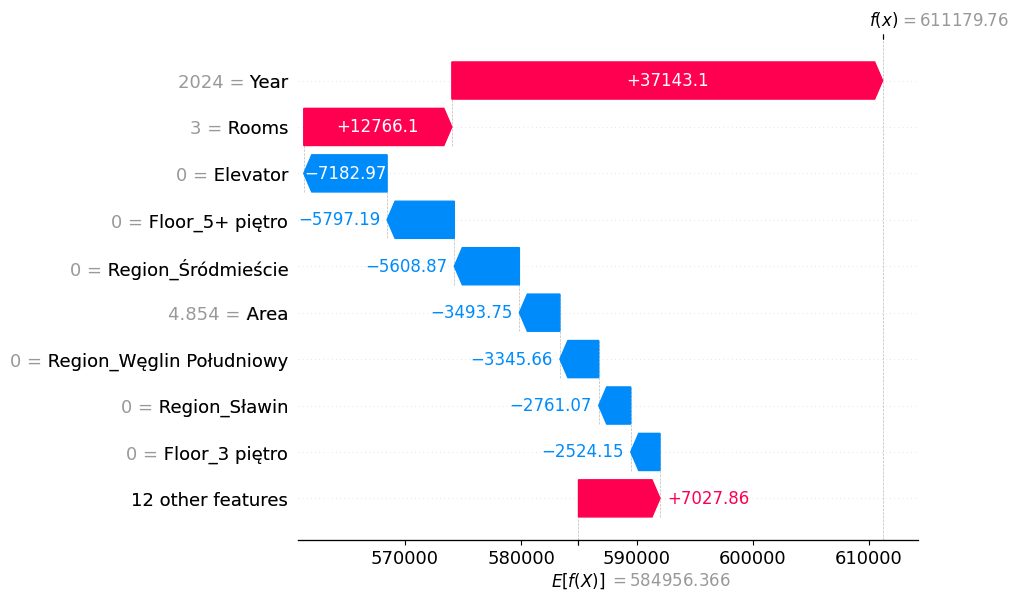

In [107]:
input_data = pd.DataFrame({
    'Area': [59.5],
    'Elevator': [0],
    'Year': [2024],
    'Rooms': [3],
    'Floor': ['1 piętro'],
    'Region': ['Bronowice']
})

price, lower, upper, plot = predict_house_price(stacking_model, input_data)

print(f"Predicted Price: {price} PLN")
print(f"95% Prediction Interval: [{lower}, {upper}] PLN")
display(plot)

![image2.png](description_images/image2.jpg)

In [108]:
input_data = pd.DataFrame({
    'Area': [57.41],
    'Elevator': [0],
    'Year': [2012],
    'Rooms': [3],
    'Floor': ['5 piętro'],
    'Region': ['Kalinowszczyzna']
})

price, lower, upper, plot = predict_house_price(stacking_model, input_data, significance_level=0.9)

print(f"Predicted Price: {price} PLN")
print(f"90% Prediction Interval: [{lower}, {upper}] PLN")
# display(plot)

Predicted Price: 676,217.64 PLN
90% Prediction Interval: [621,433.29, 731,001.98] PLN


![image3.png](description_images/image3.jpg)

In [ ]:
# Define user input
input_data = pd.DataFrame({
    'Area': [35.3],
    'Elevator': [0],
    'Year': [1964],
    'Rooms': [2],
    'Floor': ['parter'],
    'Region': ['Wieniawa']
})

price, lower, upper, plot = predict_house_price(stacking_model, input_data)

print(f"Predicted Price: {price} PLN")
print(f"95% Prediction Interval: [{lower}, {upper}] PLN")
# display(plot)

Predicted Price: 391,948.36 PLN
95% Prediction Interval: [326,668.79, 457,227.94] PLN


The **Stacking model** predicts house prices accurately based on key features. Since manual predictions are inconvenient, I use a **FastAPI app** for faster queries. Some listings lack details (e.g., floor, year, elevator), so missing values are **filled with the median or mode** to ensure reliable predictions.

## 9. Conclusion

This project successfully developed a house price prediction model using tree-based algorithms, specifically **CatBoost** and **Random Forest**. The combination of these models in a **Stacking Model** demonstrated significantly better performance compared to linear models and neural networks. The stacking approach allowed the model to capture complex relationships between features and improve overall prediction accuracy. 

The model was thoroughly evaluated on both training and unseen test data, where it achieved strong performance in terms of R², MAE, RMSE, MAPE and RMSLE. The model was saved for future use, and a dedicated function was created to enable predictions on new data. Real-world data from Otodom was used to test the model, and it showed **very promising results**, confirming the model's ability to generalize to new, unseen data.  

To better understand the model's decision-making process, I explored feature importance and SHAP (SHapley Additive exPlanations) values. This provided deeper insights into how different features contribute to house price predictions, enhancing interpretability and trust in the model.

**Potential Improvements**  
- **Property Condition** – Add a feature for interior quality, renovation status, and materials used.  
- **Quality Metric** – Combine renovation status and materials into a single composite score.  
- **External Data** – Include data on crime rates, amenities, school ratings, and environment.  
- **Feature Engineering** – Refine existing features and add interaction terms.